# Screen Modelling And Clustering for ASD

In [203]:
import sqlite3
from sqlite3 import Error
from sqlite3 import IntegrityError
from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
import pandas as pd
import io
import requests
import numpy
import seaborn as sns
from scipy import stats
import math
from scipy.stats import ttest_ind
from tqdm import tqdm

## Clustering Playtest

The below cells are for exploring clustering functionalities. Currently under development.

In [204]:
conn = sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
tstat_gene = pd.read_sql_query(f"SELECT * FROM tstat_gene_data", conn)
conn.close()

In [205]:
data = tstat_gene.drop(tstat_gene[tstat_gene.Gene == "N2"].index)
data = data.drop(columns=['Spontaneous Recovery of Response Duration',
                          'Spontaneous Recovery of Response Probability',
                          'Spontaneous Recovery of Response Speed'])
data_na = data.dropna().reset_index().drop(columns=['index'])
data_na.head(10)

Gene     Width    Length      Area  Instantaneous Speed  \
0    C29E4.10 -0.647055 -0.185658 -0.439891             0.902499   
1    F32D8.13  0.777410  0.113354  0.436028            -0.246369   
2     F53B2.5 -0.301572 -0.184646 -0.406214             2.560500   
3    F54B11.5 -0.833726 -0.436230 -0.755943             0.667368   
4     F55C5.7 -0.735903 -1.264234 -0.681969            -0.386983   
5    T08G11.1 -1.088150 -1.824558 -1.687120             0.171246   
6     T20F7.3 -0.503499 -0.469091 -0.470265            -0.185138   
7     W07B8.4 -0.576967 -0.620720 -0.424708             0.494724   
8     W07B8.5  0.387555  0.033065  0.424338            -0.055088   
9  Y18D10A.22 -0.809437 -0.772804 -0.691180            -0.002940   

   Interval Speed  Angular Speed      Bias  Aspect Ratio      Kink  ...  \
0        0.928335       1.204435  1.017620     -0.249281 -0.597715  ...   
1       -0.123728      -0.476608 -0.002676     -0.013489 -0.149009  ...   
2        1.611415       2.544994  2.637826      0.616906  0.196222  ...   
3        0.703403       0.875220  0.711684     -0.417555 -0.372645  ...   
4       -0.730350      -0.194881  0.192844     -0.376255 -0.629048  ...   
5        0.214668       0.781983  0.411728      1.001609  0.770279  ...   
6       -0.307934      -0.135628 -0.417237     -0.701360 -0.749175  ...   
7        0.273801       0.514285  0.502154     -0.545952 -0.977184  ...   
8       -0.314784       0.104489  0.021153     -0.086559 -0.487370  ...   
9       -0.070907      -0.273864  0.726390      0.084552 -0.173583  ...   

   Initial Response Duration  Initial Response Probability  \
0                  -0.382671                     -1.116753   
1                   0.496580                     -0.442789   
2                   0.880319                      0.359874   
3                  -0.220220                     -1.279735   
4                   2.599804                     -0.170001   
5                   0.348635                     -0.210835   
6                   0.274552                      0.248204   
7                   1.524722                      0.323142   
8                   1.338575                     -0.101845   
9                   0.752436                     -0.023713   

   Initial Response Speed  Final Response Duration  \
0                0.364692                -1.973002   
1               -0.432684                 0.196056   
2                1.192820                 1.398358   
3                0.368981                -0.094378   
4               -0.567830                 0.393475   
5                0.027378                -0.147517   
6               -0.098735                -2.066209   
7                1.324903                -0.623930   
8                0.501077                 0.331478   
9               -0.259683                 1.019924   

   Final Response Probability  Final Response Speed  \
0                   -0.538532             -0.441958   
1                   -0.567687              0.251047   
2                   -0.149340             -0.141870   
3                   -1.292243              0.214204   
4                    2.865312             -0.443459   
5                   -0.173955             -0.785603   
6                    0.799006             -1.561896   
7                    1.583315              0.471669   
8                    1.332169             -0.244955   
9                    0.445450             -0.737660   

   Habituation of Response Duration  Habituation of Respones Probability  \
0                          0.089889                            -1.065384   
1                          0.357877                             0.811631   
2                          0.151822                             0.550300   
3                         -0.199469                            -0.766943   
4                          1.819301                            -1.971032   
5                          0.362031                            -0.084357   
6                 

In [206]:
DOP_Genes=['cat-2','dop-3','bas-1','dat-1','dop-1','cat-1']

In [207]:
PARK_Genes=['T08G11.1',
            'djr-1.1',
            'djr-1.2',
            'ifg-1',
            'rme-8',
            'vps-35',
            'pdr-1',
            'pink-1',
            'lrk-1',
            'catp-6',
            'cats-7',
            'gba-1',
            'gba-2',
            'gba-4',
            'gba-3',
            'ubh-1',
            'ubh-2',
            'ubh-3',
            'gyf-1',
            'ipla-3',
            'unc-26']
print(PARK_Genes)

['T08G11.1', 'djr-1.1', 'djr-1.2', 'ifg-1', 'rme-8', 'vps-35', 'pdr-1', 'pink-1', 'lrk-1', 'catp-6', 'cats-7', 'gba-1', 'gba-2', 'gba-4', 'gba-3', 'ubh-1', 'ubh-2', 'ubh-3', 'gyf-1', 'ipla-3', 'unc-26']


In [208]:
for i in range(len(data_na)):
    if data_na.loc[i, "Gene"] in DOP_Genes:
        data_na.loc[i, "Screen"] = "DOPAMINE"

In [209]:
data_na_no_unc = data_na.copy()
list_to_drop = []
for i in range(len(data_na_no_unc)):
    if "unc" in data_na_no_unc.loc[i, "Gene"]:
        print(data_na_no_unc.loc[i, "Gene"]+ "-" + "yes")
        list_to_drop.append(i)
        print("adding this unc gene to list to drop")
    else:
        print(data_na_no_unc.loc[i, "Gene"]+ "-" + "no")
print("-"*50)
print(list_to_drop)

C29E4.10-no
F32D8.13-no
F53B2.5-no
F54B11.5-no
F55C5.7-no
T08G11.1-no
T20F7.3-no
W07B8.4-no
W07B8.5-no
Y18D10A.22-no
acr-12-no
acr-3-no
acr-6-no
acr-8-no
bas-1-no
cat-1-no
cat-2-no
cat-4-no
chd-1-no
chd-7-no
clh-5-no
cnd-7-no
cpr-5-no
cpr-1-no
cpr-2-no
cpr-3-no
cpr-4-no
cpr-6-no
cpr-8-no
cpr-9-no
crls-1-no
csb-1-no
dat-1-no
djr-1.1-no
djr-1.2-no
dnj-25-no
dop-1-no
dop-3-no
dpy-22-no
dve-1-no
exp-2-no
gba-1-no
gba-2-no
gba-3-no
gba-4-no
gbf-1-no
gck-3-no
gipc-1-no
gipc-2-no
glo-1-no
gyf-1-no
hipr-1-no
igcm-2-no
ima-2-no
kvs-1-no
kvs-2-no
kvs-3-no
kvs-4-no
kvs-5-no
let-19-no
lfe-2-no
lfe-2-sy326-no
lrk-1-no
mbk-1-no
mbl-1-no
mbr-1-no
mig-15-no
mig-32-no
mop-25.1-no
mop-25.2-no
ncs-4-no
ncs-5-no
ncs-7-no
pamn-1-no
pdr-1-no
pgrn-1-no
pink-1-no
ptl-1-no
rksd-1-no
sac-2-no
scav-1-no
scav-2-no
set-2-no
sipa-1-no
snb-5-no
snb-7-no
unc-10-yes
adding this unc gene to list to drop
unc-43-yes
adding this unc gene to list to drop
unc-57-yes
adding this unc gene to list to drop
unc-59-yes
adding thi

In [210]:
pd.set_option('display.max_rows', None)
data_na_no_unc = data_na_no_unc.drop(list_to_drop).reset_index()
data_na_no_unc

index                     Gene     Width    Length      Area  \
0        0                 C29E4.10 -0.647055 -0.185658 -0.439891   
1        1                 F32D8.13  0.777410  0.113354  0.436028   
2        2                  F53B2.5 -0.301572 -0.184646 -0.406214   
3        3                 F54B11.5 -0.833726 -0.436230 -0.755943   
4        4                  F55C5.7 -0.735903 -1.264234 -0.681969   
5        5                 T08G11.1 -1.088150 -1.824558 -1.687120   
6        6                  T20F7.3 -0.503499 -0.469091 -0.470265   
7        7                  W07B8.4 -0.576967 -0.620720 -0.424708   
8        8                  W07B8.5  0.387555  0.033065  0.424338   
9        9               Y18D10A.22 -0.809437 -0.772804 -0.691180   
10      10                   acr-12 -0.199792 -0.452700 -0.333528   
11      11                    acr-3  0.399610 -0.465177 -0.153709   
12      12                    acr-6 -0.021417 -0.660400 -0.257652   
13      13                    acr-8 -0.421746 -0.595702 -0.750707   
14      14                    bas-1 -0.257987 -0.172294 -0.251692   
15      15                    cat-1 -0.610769 -1.338709 -0.964875   
16      16                    cat-2  0.770869  0.212302  0.437689   
17      17                    cat-4 -1.749028 -1.747868 -1.950869   
18      18                    chd-1 -0.025052 -0.471114 -0.235348   
19      19                    chd-7 -2.014033 -1.998739 -1.635833   
20      20                    clh-5 -3.185440 -4.294430 -3.568661   
21      21                    cnd-7 -0.101667 -0.012232 -0.143004   
22      22                    cpr-5 -0.215152 -0.499949 -0.515075   
23      23                    cpr-1 -0.494368 -0.427531 -0.664506   
24      24                    cpr-2  1.004219 -0.539484  0.050945   
25      25                    cpr-3  0.076243 -0.713867 -0.493277   
26      26                    cpr-4 -0.952111  0.061245 -0.252445   
27      27                    cpr-6 -0.314767 -0.651748 -0.609151   
28      28                    cpr-8 -0.977973 -2.422364 -2.041720   
29      29                    cpr-9 -1.458762 -0.934824 -1.143079   
30      30                   crls-1  0.073512 -0.103053 -0.007571   
31      31                    csb-1 -0.109726 -2.292823 -1.181361   
32      32                    dat-1  0.542530 -0.262890 -0.531082   
33      33                  djr-1.1 -2.561684 -2.792809 -1.965044   
34      34                  djr-1.2 -0.517943 -0.280899 -0.302719   
35      35                   dnj-25 -0.177087 -0.834167 -0.803394   
36      36                    dop-1 -0.265143  0.047555 -0.166258   
37      37                    dop-3 -0.087538  0.012935 -0.112666   
38      38                   dpy-22 -2.869700 -1.554017 -2.449856   
39      39                    dve-1 -0.885665  0.098622 -0.396399   
40      40                    exp-2 -0.919077 -1.520668 -1.103937   
41      41                    gba-1 -0.923395 -1.502189 -1.507740   
42      42                    gba-2 -1.053768 -0.902080 -0.849275   
43      43                    gba-3 -0.485799 -0.479399 -0.732023   
44      44                    gba-4 -0.567142  0.113404 -0.046330   
45      45                    gbf-1  0.723327  0.137069  0.490403   
46      46                    gck-3 -1.922366 -0.642159 -1.068742   
47      47                   gipc-1  0.311408  0.008613  0.115935   
48      48                   gipc-2 -0.020824 -0.536743 -0.445558   
49      49                    glo-1 -1.436469 -2.200701 -2.253782   
50      50                    gyf-1  0.299860 -0.367724 -0.065100   
51      51                   hipr-1 -1.620691 -1.409749 -1.658909   
52      52                   igcm-2 -0.560189 -0.918781 -0.723225   
53      53                    ima-2 -1.699537 -1.998765 -1.643293   
54      54                    kvs-1 -0.756970 -2.815008 -0.976555   
55      55                    kvs-2  0.179400 -0.033857  0.100352   
56      56                    kvs-3 -0.190031 -0.556703 -0.417162   
57 

In [236]:
# data_na_no_unc = data_na_no_unc.drop(columns=['index'])
# print(data_na_no_unc)

data_na = data_na_no_unc.copy().drop(columns=['index'])

data_na

Gene     Width    Length      Area  \
0                   C29E4.10 -0.647055 -0.185658 -0.439891   
1                   F32D8.13  0.777410  0.113354  0.436028   
2                    F53B2.5 -0.301572 -0.184646 -0.406214   
3                   F54B11.5 -0.833726 -0.436230 -0.755943   
4                    F55C5.7 -0.735903 -1.264234 -0.681969   
5                   T08G11.1 -1.088150 -1.824558 -1.687120   
6                    T20F7.3 -0.503499 -0.469091 -0.470265   
7                    W07B8.4 -0.576967 -0.620720 -0.424708   
8                    W07B8.5  0.387555  0.033065  0.424338   
9                 Y18D10A.22 -0.809437 -0.772804 -0.691180   
10                    acr-12 -0.199792 -0.452700 -0.333528   
11                     acr-3  0.399610 -0.465177 -0.153709   
12                     acr-6 -0.021417 -0.660400 -0.257652   
13                     acr-8 -0.421746 -0.595702 -0.750707   
14                     bas-1 -0.257987 -0.172294 -0.251692   
15                     cat-1 -0.610769 -1.338709 -0.964875   
16                     cat-2  0.770869  0.212302  0.437689   
17                     cat-4 -1.749028 -1.747868 -1.950869   
18                     chd-1 -0.025052 -0.471114 -0.235348   
19                     chd-7 -2.014033 -1.998739 -1.635833   
20                     clh-5 -3.185440 -4.294430 -3.568661   
21                     cnd-7 -0.101667 -0.012232 -0.143004   
22                     cpr-5 -0.215152 -0.499949 -0.515075   
23                     cpr-1 -0.494368 -0.427531 -0.664506   
24                     cpr-2  1.004219 -0.539484  0.050945   
25                     cpr-3  0.076243 -0.713867 -0.493277   
26                     cpr-4 -0.952111  0.061245 -0.252445   
27                     cpr-6 -0.314767 -0.651748 -0.609151   
28                     cpr-8 -0.977973 -2.422364 -2.041720   
29                     cpr-9 -1.458762 -0.934824 -1.143079   
30                    crls-1  0.073512 -0.103053 -0.007571   
31                     csb-1 -0.109726 -2.292823 -1.181361   
32                     dat-1  0.542530 -0.262890 -0.531082   
33                   djr-1.1 -2.561684 -2.792809 -1.965044   
34                   djr-1.2 -0.517943 -0.280899 -0.302719   
35                    dnj-25 -0.177087 -0.834167 -0.803394   
36                     dop-1 -0.265143  0.047555 -0.166258   
37                     dop-3 -0.087538  0.012935 -0.112666   
38                    dpy-22 -2.869700 -1.554017 -2.449856   
39                     dve-1 -0.885665  0.098622 -0.396399   
40                     exp-2 -0.919077 -1.520668 -1.103937   
41                     gba-1 -0.923395 -1.502189 -1.507740   
42                     gba-2 -1.053768 -0.902080 -0.849275   
43                     gba-3 -0.485799 -0.479399 -0.732023   
44                     gba-4 -0.567142  0.113404 -0.046330   
45                     gbf-1  0.723327  0.137069  0.490403   
46                     gck-3 -1.922366 -0.642159 -1.068742   
47                    gipc-1  0.311408  0.008613  0.115935   
48                    gipc-2 -0.020824 -0.536743 -0.445558   
49                     glo-1 -1.436469 -2.200701 -2.253782   
50                     gyf-1  0.299860 -0.367724 -0.065100   
51                    hipr-1 -1.620691 -1.409749 -1.658909   
52                    igcm-2 -0.560189 -0.918781 -0.723225   
53                     ima-2 -1.699537 -1.998765 -1.643293   
54                     kvs-1 -0.756970 -2.815008 -0.976555   
55                     kvs-2  0.179400 -0.033857  0.100352   
56                     kvs-3 -0.190031 -0.556703 -0.417162   
57                     kvs-4 -0.416389 -1.305262 -0.921138   
58                     kvs-5 -0.249764 -1.069144 -0.589528   
59                    let-19  0.195439  0.149730  0.134600   
60                     lfe-2 -0.442164  0.314215  0.081033   
61               lfe-2-sy326 -2.517255 -0.485127 -1.268077   
62                     lrk-1 -1.363985 -0.825989 -1.269065   
63                     mbk-1 -2.882795 -2.713121 -2.8470

# Playing with Feature Importance and Selection...

In [237]:
category = data_na.pop("Screen")
lut = dict(zip(category.unique(), "kkrbkk"))
row_colors = category.map(lut)
print(category)
print(category.unique())

0                PD_Screen
1                PD_Screen
2                PD_Screen
3                PD_Screen
4                PD_Screen
5                PD_Screen
6                PD_Screen
7                PD_Screen
8                PD_Screen
9                PD_Screen
10               PD_Screen
11               PD_Screen
12               PD_Screen
13               PD_Screen
14                DOPAMINE
15                DOPAMINE
16                DOPAMINE
17               PD_Screen
18               PD_Screen
19               PD_Screen
20               PD_Screen
21               PD_Screen
22               PD_Screen
23               PD_Screen
24               PD_Screen
25               PD_Screen
26               PD_Screen
27               PD_Screen
28               PD_Screen
29               PD_Screen
30               PD_Screen
31               PD_Screen
32                DOPAMINE
33               PD_Screen
34               PD_Screen
35               PD_Screen
36                DOPAMINE
3

In [238]:
gene_labels = data_na.pop("Gene")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


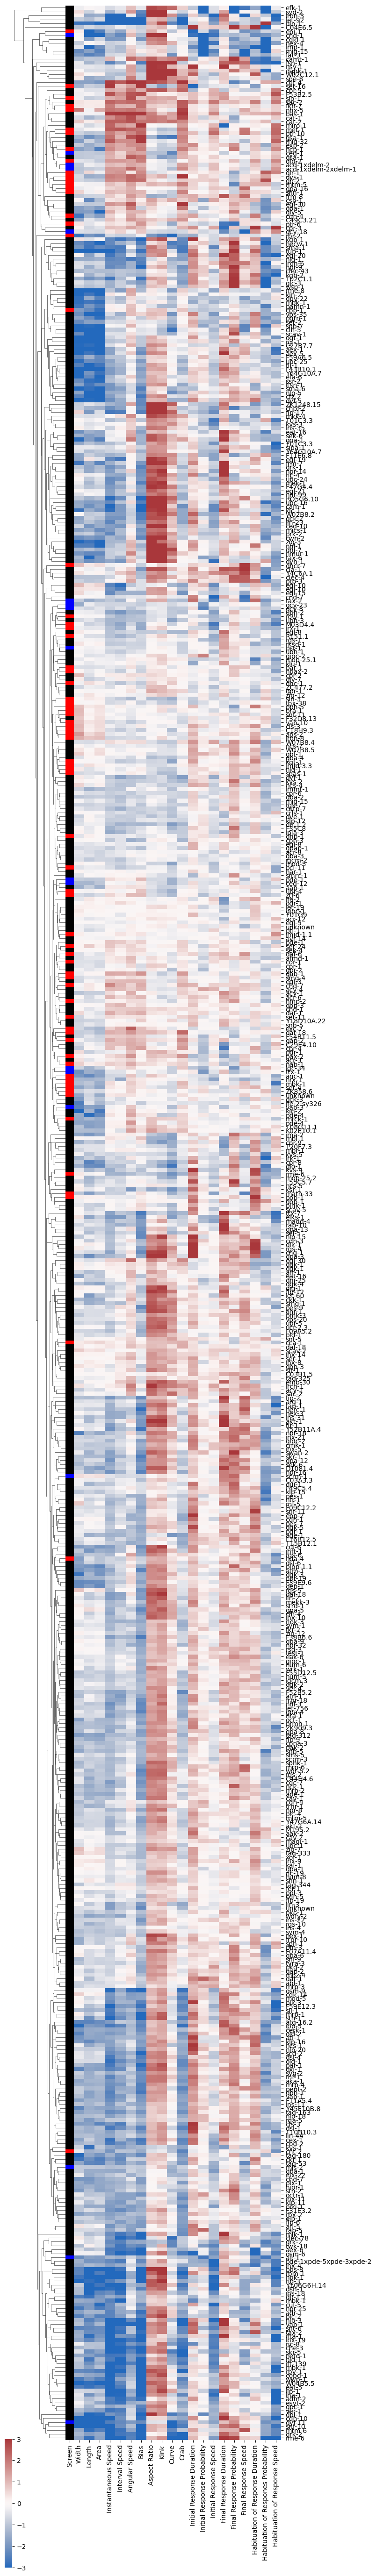

In [239]:
sns.clustermap(
    data_na,
    figsize=(8, 55),
    dendrogram_ratio=(0.2,0),
    cmap=sns.color_palette("vlag", as_cmap=True),
    vmax=3,
    vmin=-3,
    cbar_pos=(0, 0, 0.02, 0.05),
    row_colors=row_colors,
    # method = 'ward',
    # metric = 'canberra',
    row_cluster=True,
    col_cluster=False,
    yticklabels=gene_labels,
)

## Set Input (X) and Output (Y, Classification)

In [240]:
# making labels(Gene), X(features) and Y (target)
Y = category
# Y
X = data_na
# X
labels = gene_labels
# labels

X
Y

0                PD_Screen
1                PD_Screen
2                PD_Screen
3                PD_Screen
4                PD_Screen
5                PD_Screen
6                PD_Screen
7                PD_Screen
8                PD_Screen
9                PD_Screen
10               PD_Screen
11               PD_Screen
12               PD_Screen
13               PD_Screen
14                DOPAMINE
15                DOPAMINE
16                DOPAMINE
17               PD_Screen
18               PD_Screen
19               PD_Screen
20               PD_Screen
21               PD_Screen
22               PD_Screen
23               PD_Screen
24               PD_Screen
25               PD_Screen
26               PD_Screen
27               PD_Screen
28               PD_Screen
29               PD_Screen
30               PD_Screen
31               PD_Screen
32                DOPAMINE
33               PD_Screen
34               PD_Screen
35               PD_Screen
36                DOPAMINE
3

In [241]:
print(Y.unique())
# Y = Y.replace("ASD_Screen", "Outgroup")
Y = Y.replace("PD_Screen", "Outgroup") #Rerun kernel with this for in for ASD
Y = Y.replace("Glia_Genes_Screen", "Outgroup")
Y = Y.replace("G-Proteins_Screen", "Outgroup")
Y = Y.replace("Neuron_Genes_Screen", "Outgroup")
Y = Y.replace("DOPAMINE", "Outgroup")
print(Y.unique())
list_Y=['ASD_Screen','Outgroup']
print(list_Y)

['PD_Screen' 'DOPAMINE' 'ASD_Screen' 'Glia_Genes_Screen'
 'G-Proteins_Screen' 'Neuron_Genes_Screen']
['Outgroup' 'ASD_Screen']
['ASD_Screen', 'Outgroup']


## Oversample

### You want to make sure you oversample AFTER your train_test_split!! And only oversample the training set!!

In [217]:
from imblearn.over_sampling import SVMSMOTE
from collections import Counter

oversample = SVMSMOTE()
X_Oversampled, Y_Oversampled = oversample.fit_resample(X,Y)
# X_OS, Y_OS = oversample.fit_resample(X,Y)

counter = Counter(Y_Oversampled)
counter_og = Counter(Y)

print("Oversampled: ", counter)
print("Original: ", counter_og)

Oversampled:  Counter({'Outgroup': 548, 'ASD_Screen': 548})
Original:  Counter({'Outgroup': 548, 'ASD_Screen': 72})


## Random Forrest Classifier

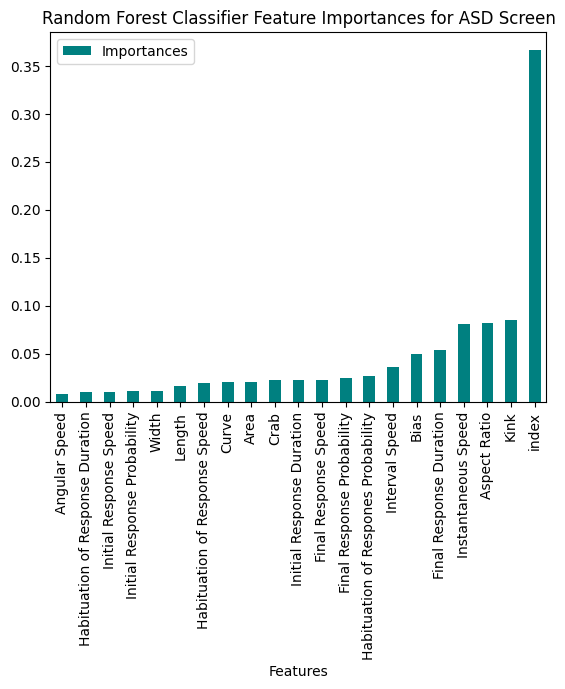

In [218]:
from sklearn.ensemble import RandomForestClassifier

# create random forest model with hyperparameters (keeping default to start)
model = RandomForestClassifier()
model.fit(X_Oversampled, Y_Oversampled)

# get the importance of the resulting features
importances = model.feature_importances_

# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# print(final_df)

# sort in ascending order to better visualzation
final_df = final_df.sort_values('Importances')

# plot the feature importance in bars
final_df.plot.bar(x = 'Features', y='Importances',color = 'teal', title = 'Random Forest Classifier Feature Importances for ASD Screen')
plt.savefig('/Users/Joseph/Desktop/ASD_RandomForestFeatureImportances.png', bbox_inches='tight')


## Information Gain

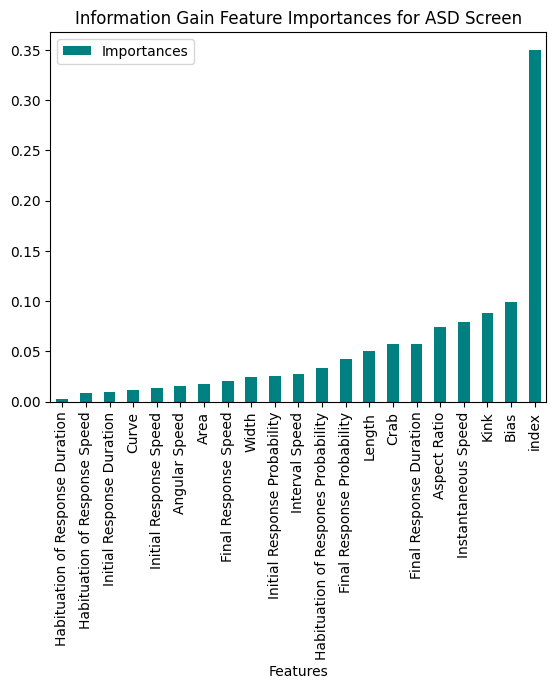

In [219]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

importances = mutual_info_classif(X,Y)
# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# print(final_df)
# sort in ascending order to better visualzation
final_df = final_df.sort_values('Importances')
# plot the feature importance in bars
final_df.plot.bar(x = 'Features', y='Importances',color = 'teal', title = 'Information Gain Feature Importances for ASD Screen')
plt.savefig('/Users/Joseph/Desktop/ASD_InfoGainFeatureImportances.png', bbox_inches='tight')

## Fisher Score

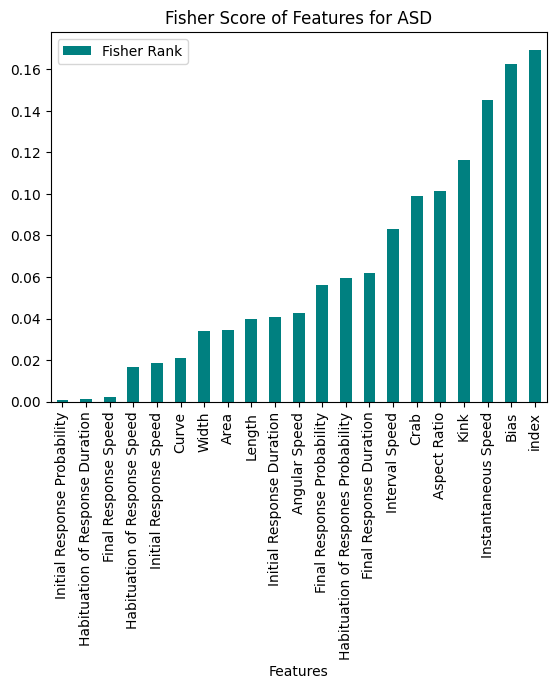

In [220]:
from skfeature.function.similarity_based import fisher_score
%matplotlib inline

ranks = fisher_score.fisher_score(X.to_numpy(),Y.to_numpy())

# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Fisher Rank":ranks})
final_df.set_index('Fisher Rank')
# print(final_df)
# sort in ascending order to better visualzation
final_df = final_df.sort_values('Fisher Rank')
# plot the feature importance in bars
final_df.plot(kind='bar',x = 'Features', y='Fisher Rank',color = 'teal', title = "Fisher Score of Features for ASD")
plt.savefig('/Users/Joseph/Desktop/ASD_FisherScoreFeatureImportances.png', bbox_inches='tight')

## Univariate (ANOVA) Modeling

### k = 5~7 yields best results

In [221]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# # Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
oversample = SVMSMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying ANOVA-based feature selection
k_best = 8  # Choose the number of top features you want to select
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

# Displaying selected feature indices
selected_indices = np.where(selector.get_support())[0]
selected_features = X.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected features:", selected_features)
# print(X_train_selected)
# Optionally, you can train a model on the selected features
# For example, using a simple classifier like Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(X_train_selected, Y_train)
# Accuracy 0.8217054263565892

# model = LogisticRegression(random_state=42)  
# model.fit(X_train_selected, Y_train)
# Accuracy 0.7286821705426356

# Predicting on the test set
y_pred = model.predict(X_test_selected)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [ 0  2  4  5  7  8  9 11]
Selected features: Index(['index', 'Length', 'Instantaneous Speed', 'Interval Speed', 'Bias',
       'Aspect Ratio', 'Kink', 'Crab'],
      dtype='object')
Accuracy on the test set: 0.967741935483871


## Forward Feature Selection

In [222]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# # Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
oversample = SVMSMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)


# Standardizing the features
scaler = StandardScaler()
X_Train = scaler.fit_transform(X_train_OS)
X_Test = scaler.transform(X_test)

# Applying ANOVA-based feature selection
k_best = 7  # Choose the number of top features you want to select
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_Train, Y_train_OS)
X_test_selected = selector.transform(X_test)

# Displaying selected feature indices
selected_indices = np.where(selector.get_support())[0]
selected_features = X.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected features:", selected_features)
# print(X_train_selected)
# Optionally, you can train a model on the selected features
# For example, using a simple classifier like Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# model = RandomForestClassifier()
# model.fit(X_train_selected, Y_train_OS)
# Accuracy 0.8217054263565892

model = LogisticRegression(random_state=42)  
model.fit(X_train_selected, Y_train_OS)
# Accuracy 0.7286821705426356

# Predicting on the test set
y_pred = model.predict(X_test_selected)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [ 0  2  4  7  8  9 19]
Selected features: Index(['index', 'Length', 'Instantaneous Speed', 'Bias', 'Aspect Ratio',
       'Kink', 'Habituation of Respones Probability'],
      dtype='object')
Accuracy on the test set: 0.8790322580645161


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


## More involved algorithms (still forward feature selection, but this time using Random Forest)

In [223]:
import random

fruits = ["apple","pineapple","orange"]

while len(fruits) > 0:
    print("original list: ", fruits)
    rand = random.choice(fruits)
    print("random choice: ", rand)
    fruits.remove(rand)
    print("new list: ", fruits)
    print("starting again...")


# for fruit in fruits:
#     print("original list: ", fruits)
#     rand = random.choice(fruits)
#     print("random choice: ", rand)
#     fruits.remove(rand)
#     print("new list: ", fruits)
#     print("starting again...")

print(fruits)


original list:  ['apple', 'pineapple', 'orange']
random choice:  pineapple
new list:  ['apple', 'orange']
starting again...
original list:  ['apple', 'orange']
random choice:  apple
new list:  ['orange']
starting again...
original list:  ['orange']
random choice:  orange
new list:  []
starting again...
[]


In [279]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import random

def forward_feature_selection(X_train, X_test, y_train, y_test, model, max_features=10):
    """
    Forward Feature Selection
    """
    selected_features = []
    best_score = 0

    while len(selected_features) < max_features if max_features else X_train.shape[1]:
        remaining_features = [feature for feature in range(X_train.shape[1]) if feature not in selected_features]
        candidate_scores = []

        while len(remaining_features) > 0:
            rand_feature = random.choice(remaining_features)
            remaining_features.remove(rand_feature)
            current_features = selected_features + [rand_feature]
            model.fit(X_train[:, current_features], y_train)
            y_pred = model.predict(X_test[:, current_features])
            acc_score = accuracy_score(y_test, y_pred)
            F1 = f1_score(y_test,y_pred, pos_label='ASD_Screen')
            candidate_scores.append((rand_feature, F1))
            

        # for feature in remaining_features:
        #     current_features = selected_features + [feature]
        #     model.fit(X_train[:, current_features], y_train)
        #     y_pred = model.predict(X_test[:, current_features])
        #     acc_score = accuracy_score(y_test, y_pred)
        #     F1 = f1_score(y_test,y_pred, pos_label='ASD_Screen')
        #     candidate_scores.append((feature, F1))

        # Select the feature that gives the best score
        best_candidate = max(candidate_scores, key=lambda x: x[1])

        # Check if adding the feature improves the model
        if best_candidate[1] > best_score:
            selected_features.append(best_candidate[0])
            best_score = best_candidate[1]
        else:
            break

    return selected_features

In [313]:
from imblearn.over_sampling import SVMSMOTE
# # Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
oversample = SVMSMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)

# Standardizing the features
scaler = StandardScaler()
X_Train = scaler.fit_transform(X_train_OS)
X_Test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(criterion = 'entropy', random_state=42)

# Performing forward feature selection
selected_features = forward_feature_selection(X_Train, X_Test, Y_train_OS, Y_test, model)

print("Selected feature indices:", selected_features)
print("Selected features:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_Train[:, selected_features], Y_train_OS)
y_pred = model.predict(X_Test[:, selected_features])
y_prob = np.max(model.predict_proba(X_Test[:, selected_features]), axis=1)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)
F1 = f1_score(Y_test,y_pred, pos_label='ASD_Screen')
print("F1-Measure on the test set:", F1)

# pred_conf = pd.DataFrame(np.array([y_pred, y_prob]), columns = ["Prediction", "Confidence"])
d = {'prediction': y_pred, 'confidence': y_prob, "class":Y_test}
df = pd.DataFrame(data=d)
print(df)
# print(pred_conf)

Selected feature indices: [6, 16, 11, 4]
Selected features: Index(['Bias', 'Final Response Speed', 'Initial Response Duration',
       'Interval Speed'],
      dtype='object')
Accuracy on the test set: 0.8709677419354839
F1-Measure on the test set: 0.5789473684210527
     prediction  confidence       class
49     Outgroup        0.52    Outgroup
584    Outgroup        1.00    Outgroup
82     Outgroup        0.89    Outgroup
305    Outgroup        0.98    Outgroup
109  ASD_Screen        0.87  ASD_Screen
608    Outgroup        0.53    Outgroup
268    Outgroup        0.97    Outgroup
353    Outgroup        1.00    Outgroup
328    Outgroup        1.00    Outgroup
533    Outgroup        0.88    Outgroup
281    Outgroup        1.00    Outgroup
487    Outgroup        1.00    Outgroup
234    Outgroup        1.00    Outgroup
131  ASD_Screen        0.95  ASD_Screen
2      Outgroup        0.61    Outgroup
227    Outgroup        1.00    Outgroup
578    Outgroup        0.95    Outgroup
426    Outgr

Selected feature indices: [8, 15, 0, 7, 11, 6]
Selected features: Index(['Kink', 'Final Response Probability', 'Width', 'Aspect Ratio',
       'Initial Response Duration', 'Bias'],
      dtype='object')
Accuracy on the test set: 0.9112903225806451
F1-Measure on the test set: 0.6857142857142857


Selected feature indices: [8, 15, 19, 10, 4]
Selected features: Index(['Kink', 'Final Response Probability', 'Habituation of Response Speed',
       'Crab', 'Interval Speed'],
      dtype='object')
Accuracy on the test set: 0.9193548387096774
F1-Measure on the test set: 0.7058823529411765

Selected feature indices: [6, 19, 15, 4, 11, 16]
Selected features: Index(['Bias', 'Habituation of Response Speed', 'Final Response Probability',
       'Interval Speed', 'Initial Response Duration', 'Final Response Speed'],
      dtype='object')
Accuracy on the test set: 0.9354838709677419
F1-Measure on the test set: 0.7333333333333333

In [277]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.metrics import average_precision_score,f1_score, make_scorer

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# oversample = SVMSMOTE()
# X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)

# # Standardizing the features
# scaler = StandardScaler()
# X_Train = scaler.fit_transform(X_train_OS)
# X_Test = scaler.transform(X_test)

# def forward_feature_selection(X_train, y_train, model, scoring, cv=5):
#     """
#     Perform forward feature selection.
    
#     Parameters:
#     - X_train: Training features
#     - y_train: Training labels
#     - model: Model to train (RandomForestClassifier in this case)
#     - scoring: Scoring method to optimize (F1-score in this case)
#     - cv: Number of cross-validation folds
    
#     Returns:
#     - best_features: List of selected features
#     """
#     best_features = []
#     remaining_features = list(X_train.columns)
#     best_score = 0

#     while remaining_features:
#         scores = []
#         for feature in remaining_features:
#             selected_features = best_features + [feature]
#             X_train_selected = X_train[selected_features]
#             score = np.mean(cross_val_score(model, X_train_selected, y_train, cv=cv, scoring=scoring))
#             scores.append((score, feature))

#         scores.sort(reverse=True)
#         best_new_score, best_new_feature = scores[0]

#         if best_new_score > best_score:
#             best_score = best_new_score
#             best_features.append(best_new_feature)
#             remaining_features.remove(best_new_feature)
#         else:
#             break

#     return best_features

# # Define the model
# model = RandomForestClassifier(random_state=42)

# # Define the scoring method (F1-score)
# scoring = make_scorer(f1_score,pos_label='ASD_Screen')

# # Perform forward feature selection
# best_features = forward_feature_selection(X_train_OS, Y_train_OS, model, scoring)

# print("Selected features:", best_features)

# # Train the final model with selected features
# X_train_selected = X_Train_OS[best_features]
# X_test_selected = X_Test[best_features]

# model.fit(X_train_selected, Y_train_OS)
# y_pred = model.predict(X_test_selected)

# # Evaluate the final model
# final_f1_score = f1_score(y_test, y_pred,pos_label='ASD_Screen')
# print("Final F1 Score:", final_f1_score)

Selected features: ['Kink', 'Instantaneous Speed', 'Habituation of Respones Probability', 'Final Response Duration', 'Habituation of Response Speed', 'Aspect Ratio']


NameError: name 'X_Train_OS' is not defined

In [227]:
# MonteCarlo = pd.DataFrame(columns=['Feature Indices','Feature Names','Accuracy', 'F1'])
# MonteCarlo['Feature Indices'] = MonteCarlo['Feature Indices'].astype('object')
# MonteCarlo['Feature Names'] = MonteCarlo['Feature Names'].astype('object')

In [228]:
# def run_sim():

#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
#     oversample = SVMSMOTE()
#     X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)  
# # Standardizing the features
#     scaler = StandardScaler()
#     X_Train = scaler.fit_transform(X_train_OS)
#     X_Test = scaler.transform(X_test)
# # Using a simple classifier like RandomForestClassifier
#     model = RandomForestClassifier()
# # Performing forward feature selection
#     selected_features = forward_feature_selection(X_Train, X_Test, Y_train_OS, Y_test, model)
#     selected_feature_names = X.columns[selected_features]
# # print("Selected feature indices:", selected_features)
# # print("Selected features:", X.columns[selected_features])

# # Optionally, you can train a model on the selected features
#     model.fit(X_Train[:, selected_features], Y_train_OS)
#     y_pred = model.predict(X_Test[:, selected_features])
#     y_prob = np.max(model.predict_proba(X_Test[:, selected_features]), axis=1)
# # Evaluating the model
#     accuracy = accuracy_score(Y_test, y_pred)
#     F1 = f1_score(Y_test,y_pred, pos_label='ASD_Screen')
#     new_row = {'Feature Indices': set(selected_features),'Feature Names': set(selected_feature_names),'Accuracy': accuracy, 'F1': F1}
# # print(new_row)
# # print("Accuracy on the test set:", accuracy)
#     MonteCarlo.loc[i] = new_row

In [230]:
# MonteCarlo = pd.DataFrame(columns=['Feature Indices','Feature Names','Accuracy', 'F1'])
# MonteCarlo['Feature Indices'] = MonteCarlo['Feature Indices'].astype('object')
# MonteCarlo['Feature Names'] = MonteCarlo['Feature Names'].astype('object')

# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# for i in tqdm(range(5000)):
#    pool.apply_async(run_sim(), callback = "")
# pool.close()
# pool.join()

# MonteCarlo

In [ ]:
# MonteCarlo.to_csv('/Users/Joseph/Desktop/ASD_MonteCarloFeatureSelection_new5000.csv')

In [ ]:
# print(MonteCarlo.sort_values(by=['F1']))

## For selected features from feature selection processes above:

In [312]:
# selected_features = [6, 12, 14, 19, 0, 11, 13]
# selected_features = [2, 6, 7, 10, 11, 14, 19]
selected_features = [6, 19, 15, 4, 11, 16]


print("Selected feature indices:", selected_features)
print("Selected features:", X.columns[selected_features])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
oversample = SVMSMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)  
# Standardizing the features
scaler = StandardScaler()
X_Train = scaler.fit_transform(X_train_OS)
X_Test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(criterion = 'entropy', random_state=42)

# Optionally, you can train a model on the selected features
model.fit(X_Train[:, selected_features], Y_train_OS)
y_pred = model.predict(X_Test[:, selected_features])
y_prob = np.max(model.predict_proba(X_Test[:, selected_features]), axis=1) 

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)
F1 = f1_score(Y_test,y_pred, pos_label='ASD_Screen')
print("F1-Measure on the test set:", F1)
# pred_conf = pd.DataFrame(np.array([y_pred, y_prob]), columns = ["Prediction", "Confidence"])
d = {'prediction': y_pred, 'confidence': y_prob, "class":Y_test}
df = pd.DataFrame(data=d)
print(df)

Selected feature indices: [6, 19, 15, 4, 11, 16]
Selected features: Index(['Bias', 'Habituation of Response Speed', 'Final Response Probability',
       'Interval Speed', 'Initial Response Duration', 'Final Response Speed'],
      dtype='object')
Accuracy on the test set: 0.8951612903225806
F1-Measure on the test set: 0.606060606060606
     prediction  confidence       class
49     Outgroup        0.94    Outgroup
584    Outgroup        0.94    Outgroup
82     Outgroup        0.66    Outgroup
305    Outgroup        0.96    Outgroup
109  ASD_Screen        0.94  ASD_Screen
608    Outgroup        0.82    Outgroup
268    Outgroup        0.97    Outgroup
353    Outgroup        0.98    Outgroup
328    Outgroup        0.99    Outgroup
533    Outgroup        0.83    Outgroup
281    Outgroup        0.86    Outgroup
487    Outgroup        1.00    Outgroup
234    Outgroup        1.00    Outgroup
131  ASD_Screen        0.95  ASD_Screen
2      Outgroup        0.67    Outgroup
227    Outgroup       

### Saving the model:

In [ ]:
from joblib import dump, load
dump(model, '/Users/Joseph/Desktop/NRSC510B/ASD_Screen_Model.joblib') 

In [ ]:
for col in X.columns:
    print(col)

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve as roc_curve

def binaryize(inlist):
    for i in range(len(inlist)):
        if inlist[i] == 'Outgroup':
            inlist[i] = 0
        if inlist[i] == 'ASD_Screen':
            inlist[i] = 1
    return inlist

y_test_binary = binaryize(y_test.tolist())
y_pred_binary = binaryize(y_pred)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary, pos_label=1)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1-fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

In [ ]:
from sklearn.metrics import roc_auc_score 

print(np.sum(roc_df.recall[:-1]*np.diff(1-roc_df.specificity)))
print(roc_auc_score([1 if yi == 1 else 0 for yi in y_test_binary],
                    y_pred_binary))

## Backward Feature Elimination

In [244]:
X

Width    Length      Area  Instantaneous Speed  Interval Speed  \
0   -0.647055 -0.185658 -0.439891             0.902499        0.928335   
1    0.777410  0.113354  0.436028            -0.246369       -0.123728   
2   -0.301572 -0.184646 -0.406214             2.560500        1.611415   
3   -0.833726 -0.436230 -0.755943             0.667368        0.703403   
4   -0.735903 -1.264234 -0.681969            -0.386983       -0.730350   
5   -1.088150 -1.824558 -1.687120             0.171246        0.214668   
6   -0.503499 -0.469091 -0.470265            -0.185138       -0.307934   
7   -0.576967 -0.620720 -0.424708             0.494724        0.273801   
8    0.387555  0.033065  0.424338            -0.055088       -0.314784   
9   -0.809437 -0.772804 -0.691180            -0.002940       -0.070907   
10  -0.199792 -0.452700 -0.333528            -0.208878       -0.125431   
11   0.399610 -0.465177 -0.153709             0.267953        0.416563   
12  -0.021417 -0.660400 -0.257652             1.043999        0.547322   
13  -0.421746 -0.595702 -0.750707            -0.524781       -0.360127   
14  -0.257987 -0.172294 -0.251692             2.930804        3.261641   
15  -0.610769 -1.338709 -0.964875             1.623617        2.167722   
16   0.770869  0.212302  0.437689             2.423529        2.372219   
17  -1.749028 -1.747868 -1.950869             2.877392        2.438738   
18  -0.025052 -0.471114 -0.235348             0.669615        0.744157   
19  -2.014033 -1.998739 -1.635833            -1.364381       -1.245361   
20  -3.185440 -4.294430 -3.568661            -0.910986       -0.958922   
21  -0.101667 -0.012232 -0.143004            -0.832652       -0.578272   
22  -0.215152 -0.499949 -0.515075             1.227492        1.069315   
23  -0.494368 -0.427531 -0.664506            -0.135227       -0.200791   
24   1.004219 -0.539484  0.050945             0.272063        0.257806   
25   0.076243 -0.713867 -0.493277             0.892926        0.810211   
26  -0.952111  0.061245 -0.252445             0.919997        0.374220   
27  -0.314767 -0.651748 -0.609151            -0.878214       -0.758545   
28  -0.977973 -2.422364 -2.041720            -0.822507       -0.714736   
29  -1.458762 -0.934824 -1.143079             0.197858       -0.312006   
30   0.073512 -0.103053 -0.007571            -0.744420       -0.498528   
31  -0.109726 -2.292823 -1.181361             0.356793        0.478767   
32   0.542530 -0.262890 -0.531082             1.187176        0.708794   
33  -2.561684 -2.792809 -1.965044            -1.477204       -1.839468   
34  -0.517943 -0.280899 -0.302719            -1.031601       -1.396603   
35  -0.177087 -0.834167 -0.803394            -0.505691       -0.125098   
36  -0.265143  0.047555 -0.166258            -0.047897       -0.223152   
37  -0.087538  0.012935 -0.112666             0.858845        1.054062   
38  -2.869700 -1.554017 -2.449856            -0.760808       -1.278068   
39  -0.885665  0.098622 -0.396399            -0.716769       -0.894870   
40  -0.919077 -1.520668 -1.103937             1.509083        1.183331   
41  -0.923395 -1.502189 -1.507740            -1.570120       -1.607551   
42  -1.053768 -0.902080 -0.849275            -0.946658       -1.150385   
43  -0.485799 -0.479399 -0.732023            -0.491053       -0.379973   
44  -0.567142  0.113404 -0.046330            -0.408098       -0.316351   
45   0.723327  0.137069  0.490403             0.004991       -0.136367   
46  -1.922366 -0.642159 -1.068742            -0.295412       -0.647531   
47   0.311408  0.008613  0.115935            -0.023639        0.027217   
48  -0.020824 -0.536743 -0.445558            -0.326058       -0.515598   
49  -1.436469 -2.200701 -2.253782            -1.081521       -1.171387   
50   0.299860 -0.367724 -0.065100            -1.070603       -1.752907   
51  -1.620691 -1.409749 -1.658909            -1.445662       -1.270341   
52  -0.560189 -0.918781 -0.723225            -0.770334       -1.039151   
53  -1.69953

In [246]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def backward_feature_elimination(X_train, X_test, y_train, y_test, model):
    """
    Backward Feature Elimination
    """
    sselected_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# 10 features: 0.8449612403100775
# 7 features: 0.8449612403100775 <--- 7 features sweet spot
# 6 features: 0.8294573643410853
    while len(sselected_features) > 6:
        current_score = 0
        worst_feature = None

        for feature in sselected_features:
            remaining_features = [f for f in sselected_features if f != feature]
            model.fit(X_train[:, remaining_features], y_train)
            y_pred = model.predict(X_test[:, remaining_features])
            score = accuracy_score(y_test, y_pred)

            if score > current_score:
                current_score = score
                worst_feature = feature

        if worst_feature is not None:
            sselected_features.remove(worst_feature)
        else:
            break

    return sselected_features

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(X_train.shape)
# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Performing Backward Feature Elimination (BFE)
sselected_features = backward_feature_elimination(X_train, X_test, y_train, y_test, model)

print("Selected feature indices:", sselected_features)
print("Selected features:", X.columns[sselected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train[:, sselected_features], y_train)
y_pred = model.predict(X_test[:, sselected_features])

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)
F1 = f1_score(Y_test,y_pred, pos_label='ASD_Screen')
print("F1-Measure on the test set:", F1)

Selected feature indices: [9, 12, 13, 15, 16, 19]
Selected features: Index(['Curve', 'Initial Response Probability', 'Initial Response Speed',
       'Final Response Probability', 'Final Response Speed',
       'Habituation of Response Speed'],
      dtype='object')
Accuracy on the test set: 0.9193548387096774
F1-Measure on the test set: 0.5454545454545455


## Recursive Feature Elimination

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Performing Recursive Feature Elimination (RFE)
num_features_to_select = 5  # Choose the number of features to select
rfe = RFE(estimator=model, n_features_to_select=num_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Displaying selected feature indices
selected_features = [i for i in range(len(rfe.support_)) if rfe.support_[i]]
print("Selected feature indices:", selected_features)
print("Selected feature indices:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)
F1 = f1_score(Y_test,y_pred, pos_label='ASD_Screen')
print("F1-Measure on the test set:", F1)

Selected feature indices: [1, 3, 6, 7, 14]
Selected feature indices: Index(['Length', 'Instantaneous Speed', 'Bias', 'Aspect Ratio',
       'Final Response Duration'],
      dtype='object')
Accuracy on the test set: 0.8629032258064516
F1-Measure on the test set: 0.26086956521739135


# Now Performing Clustering Of ASD_Screen Only for Profile Sub-types

In [ ]:
# PD_Screen_other = tstat_gene[tstat_gene.Screen != "ASD_Screen"].reset_index().drop(columns=['index'])
# PD_Screen_other

In [ ]:
# print(PD_Screen_other[PD_Screen_other.Gene == 'N2'])
# PD_Screen_other = PD_Screen_other.drop([5,92,111,187,606])
# print(PD_Screen_other[PD_Screen_other.Gene == 'N2']) 

In [ ]:
# PD_Screen_other1 = PD_Screen_other[['Gene','Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
#        'Final Response Duration', 'Habituation of Response Speed']]

# PD_Screen_other1 = PD_Screen_other1.dropna()
# PD_Screen_other1

In [ ]:
# PD_Screen_other_Genes=PD_Screen_other1.pop("Gene")
# PD_Screen_other1

In [ ]:
# PD_Screen_other_Genes

In [314]:
# print(tstat_gene.shape)
# print(tstat_gene.columns)
# print(tstat_gene.Screen.unique())
# print(tstat_gene.Gene[tstat_gene.Screen == "PD_Screen"])
PD_Screen = tstat_gene[tstat_gene.Screen == "ASD_Screen"].reset_index().drop(columns=['index'])
PD_Screen

Gene     Width    Length      Area  Instantaneous Speed  \
0    C18H9.3  0.940727  0.194177  0.435323            -0.616387   
1    M03D4.4 -0.150020 -0.791369 -0.629753            -1.329001   
2         N2  0.000000  0.000000  0.000000             0.000000   
3     R151.1 -0.095614 -0.545433 -0.581830            -1.093169   
4    ZK858.6 -0.860502 -0.540469 -0.659422             0.136818   
5      anc-1 -1.972727 -2.285821 -1.739887            -0.719948   
6      aps-2  1.489544  0.509199  0.794420            -0.444350   
7      bar-1 -0.572828 -0.608646 -0.526037            -0.374614   
8     bcl-11 -0.511372 -0.322406 -0.365410            -0.572417   
9      bra-1  0.975379  0.083340  0.369127            -0.265097   
10     cbp-1 -1.864270 -2.238897 -2.818095             0.211911   
11     cca-1  0.275008  0.437950  0.565773             0.317830   
12     cdh-4 -2.712687 -1.361686 -1.817794             0.608834   
13     chd-7 -0.183395  0.331217  0.033888             1.743624   
14     cls-3  1.011232  0.242002  0.481889            -0.253906   
15     cnt-2 -0.341068 -1.442944 -1.245833            -2.003523   
16     cor-1 -0.538018 -0.536588 -0.643483             0.276285   
17    daf-18 -0.890343 -0.779642 -1.210980             1.126432   
18     daf-6 -0.598686 -0.241886 -0.503193             0.360003   
19     dhc-1 -0.280547  0.470170  0.210666            -0.683127   
20    dhcr-7  0.932757  0.297658  0.482821            -0.270294   
21     dhp-1 -0.488889  0.201480 -0.021116            -0.476996   
22     dip-2 -0.463471 -0.564274 -0.917222             1.473300   
23     dys-1 -0.630593 -1.514690 -1.398715             1.875378   
24     epi-1  0.245768 -4.929581 -2.490101            -1.075450   
25     exc-7 -0.699262 -1.110217 -1.296054             0.653064   
26     fkh-7  0.336978  0.245868  0.295737             1.901735   
27     gab-1 -0.324158  0.070853  0.095906             1.234262   
28     gap-2 -0.214063 -0.590754 -0.683376             1.182710   
29     glr-1 -0.984603  0.546397 -0.292399             1.435019   
30     glr-2 -0.680767 -0.886868 -0.983669             1.692379   
31    gpa-16 -0.360119 -0.200536 -0.073929             0.573824   
32     hcp-1 -1.753869 -1.438371 -2.577492             1.671549   
33     hda-4 -1.811254 -0.528843 -1.074243            -0.708356   
34     hmp-2 -0.385919 -0.605411 -0.522733             0.193742   
35     irx-1 -0.302543 -0.426361 -0.409009            -1.114143   
36  jmjd-1.1  0.220462 -0.143039 -0.116889             0.115459   
37  jmjd-3.3 -0.449519  0.455629  0.180958             0.056857   
38     kqt-1 -0.014167 -0.108002 -0.096570            -0.506125   
39    lron-8  1.152447  0.820207  0.891807            -0.736978   
40   math-33 -1.020838 -1.806155 -1.127416            -0.796181   
41     mbk-1 -1.186244 -0.995520 -1.479700             0.478500   
42     met-1 -0.478501 -0.136384 -0.061187             2.448605   
43    mrck-1 -1.585614 -1.270159 -1.549439            -0.099045   
44     mtm-5 -0.118696 -0.211032 -0.257605             0.907158   
45     nab-1  0.673306  0.192618  0.317248             0.700821   
46     nhx-5  2.027690 -0.204245  1.236534             2.053154   
47     nlg-1  0.301280 -0.516329 -0.246151            -0.131647   
48    npax-2  0.106563 -0.396798 -0.137705            -0.512889   
49     nrx-1 -1.301334 -1.339939 -1.249017            -0.670329   
50     pax-2  0.199447 -0.095029 -0.000950             0.469496   
51     pop-1  0.254956  0.167517  0.147024            -0.331211   
52     pph-5  0.878341  0.309866  0.431825            -0.163458   
53    ptr-10 -0.767006 -1.069316 -0.978265             1.870121   
54     ptr-6  0.372084 -0.478372 -0.159329             0.460452   
55     rbr-2 -2.838090 -2.041119 -2.318613            -0.643722   
56     rme-6  0.313781 -0.229143  0.019683            -1.359581   
57     row-1 -0.011036 -0.153418 -0.102802            -0.962841   
58    set-11 -0.708515 -0.213162 -0.383441             

In [315]:
print(PD_Screen[PD_Screen.Gene == 'N2'])
PD_Screen = PD_Screen.drop([2])
print(PD_Screen[PD_Screen.Gene == 'N2']) 

  Gene  Width  Length  Area  Instantaneous Speed  Interval Speed  \
2   N2    0.0     0.0   0.0                  0.0             0.0   

   Angular Speed  Bias  Aspect Ratio  Kink  ...  Final Response Duration  \
2            0.0   0.0           0.0   0.0  ...                      0.0   

   Final Response Probability  Final Response Speed  \
2                         0.0                   0.0   

   Habituation of Response Duration  Habituation of Respones Probability  \
2                               0.0                                  0.0   

   Habituation of Response Speed  Spontaneous Recovery of Response Duration  \
2                            0.0                                        0.0   

   Spontaneous Recovery of Response Probability  \
2                                           0.0   

   Spontaneous Recovery of Response Speed      Screen  
2                                     0.0  ASD_Screen  

[1 rows x 25 columns]
Empty DataFrame
Columns: [Gene, Width, Length, Ar

In [317]:
# PD_Screen = PD_Screen.drop(columns=['index'])
PD_Screen = PD_Screen.reset_index().drop(columns=['index'])
PD_Screen

Gene     Width    Length      Area  Instantaneous Speed  \
0    C18H9.3  0.940727  0.194177  0.435323            -0.616387   
1    M03D4.4 -0.150020 -0.791369 -0.629753            -1.329001   
2     R151.1 -0.095614 -0.545433 -0.581830            -1.093169   
3    ZK858.6 -0.860502 -0.540469 -0.659422             0.136818   
4      anc-1 -1.972727 -2.285821 -1.739887            -0.719948   
5      aps-2  1.489544  0.509199  0.794420            -0.444350   
6      bar-1 -0.572828 -0.608646 -0.526037            -0.374614   
7     bcl-11 -0.511372 -0.322406 -0.365410            -0.572417   
8      bra-1  0.975379  0.083340  0.369127            -0.265097   
9      cbp-1 -1.864270 -2.238897 -2.818095             0.211911   
10     cca-1  0.275008  0.437950  0.565773             0.317830   
11     cdh-4 -2.712687 -1.361686 -1.817794             0.608834   
12     chd-7 -0.183395  0.331217  0.033888             1.743624   
13     cls-3  1.011232  0.242002  0.481889            -0.253906   
14     cnt-2 -0.341068 -1.442944 -1.245833            -2.003523   
15     cor-1 -0.538018 -0.536588 -0.643483             0.276285   
16    daf-18 -0.890343 -0.779642 -1.210980             1.126432   
17     daf-6 -0.598686 -0.241886 -0.503193             0.360003   
18     dhc-1 -0.280547  0.470170  0.210666            -0.683127   
19    dhcr-7  0.932757  0.297658  0.482821            -0.270294   
20     dhp-1 -0.488889  0.201480 -0.021116            -0.476996   
21     dip-2 -0.463471 -0.564274 -0.917222             1.473300   
22     dys-1 -0.630593 -1.514690 -1.398715             1.875378   
23     epi-1  0.245768 -4.929581 -2.490101            -1.075450   
24     exc-7 -0.699262 -1.110217 -1.296054             0.653064   
25     fkh-7  0.336978  0.245868  0.295737             1.901735   
26     gab-1 -0.324158  0.070853  0.095906             1.234262   
27     gap-2 -0.214063 -0.590754 -0.683376             1.182710   
28     glr-1 -0.984603  0.546397 -0.292399             1.435019   
29     glr-2 -0.680767 -0.886868 -0.983669             1.692379   
30    gpa-16 -0.360119 -0.200536 -0.073929             0.573824   
31     hcp-1 -1.753869 -1.438371 -2.577492             1.671549   
32     hda-4 -1.811254 -0.528843 -1.074243            -0.708356   
33     hmp-2 -0.385919 -0.605411 -0.522733             0.193742   
34     irx-1 -0.302543 -0.426361 -0.409009            -1.114143   
35  jmjd-1.1  0.220462 -0.143039 -0.116889             0.115459   
36  jmjd-3.3 -0.449519  0.455629  0.180958             0.056857   
37     kqt-1 -0.014167 -0.108002 -0.096570            -0.506125   
38    lron-8  1.152447  0.820207  0.891807            -0.736978   
39   math-33 -1.020838 -1.806155 -1.127416            -0.796181   
40     mbk-1 -1.186244 -0.995520 -1.479700             0.478500   
41     met-1 -0.478501 -0.136384 -0.061187             2.448605   
42    mrck-1 -1.585614 -1.270159 -1.549439            -0.099045   
43     mtm-5 -0.118696 -0.211032 -0.257605             0.907158   
44     nab-1  0.673306  0.192618  0.317248             0.700821   
45     nhx-5  2.027690 -0.204245  1.236534             2.053154   
46     nlg-1  0.301280 -0.516329 -0.246151            -0.131647   
47    npax-2  0.106563 -0.396798 -0.137705            -0.512889   
48     nrx-1 -1.301334 -1.339939 -1.249017            -0.670329   
49     pax-2  0.199447 -0.095029 -0.000950             0.469496   
50     pop-1  0.254956  0.167517  0.147024            -0.331211   
51     pph-5  0.878341  0.309866  0.431825            -0.163458   
52    ptr-10 -0.767006 -1.069316 -0.978265             1.870121   
53     ptr-6  0.372084 -0.478372 -0.159329             0.460452   
54     rbr-2 -2.838090 -2.041119 -2.318613            -0.643722   
55     rme-6  0.313781 -0.229143  0.019683            -1.359581   
56     row-1 -0.011036 -0.153418 -0.102802            -0.962841   
57    set-11 -0.708515 -0.213162 -0.383441             0.518630   
58    set-16 -1.483740 -0.841869 -0.972926             

In [321]:
PD_screen_no_unc = PD_Screen.copy()
PD_screen_no_unc

Gene     Width    Length      Area  Instantaneous Speed  \
0    C18H9.3  0.940727  0.194177  0.435323            -0.616387   
1    M03D4.4 -0.150020 -0.791369 -0.629753            -1.329001   
2     R151.1 -0.095614 -0.545433 -0.581830            -1.093169   
3    ZK858.6 -0.860502 -0.540469 -0.659422             0.136818   
4      anc-1 -1.972727 -2.285821 -1.739887            -0.719948   
5      aps-2  1.489544  0.509199  0.794420            -0.444350   
6      bar-1 -0.572828 -0.608646 -0.526037            -0.374614   
7     bcl-11 -0.511372 -0.322406 -0.365410            -0.572417   
8      bra-1  0.975379  0.083340  0.369127            -0.265097   
9      cbp-1 -1.864270 -2.238897 -2.818095             0.211911   
10     cca-1  0.275008  0.437950  0.565773             0.317830   
11     cdh-4 -2.712687 -1.361686 -1.817794             0.608834   
12     chd-7 -0.183395  0.331217  0.033888             1.743624   
13     cls-3  1.011232  0.242002  0.481889            -0.253906   
14     cnt-2 -0.341068 -1.442944 -1.245833            -2.003523   
15     cor-1 -0.538018 -0.536588 -0.643483             0.276285   
16    daf-18 -0.890343 -0.779642 -1.210980             1.126432   
17     daf-6 -0.598686 -0.241886 -0.503193             0.360003   
18     dhc-1 -0.280547  0.470170  0.210666            -0.683127   
19    dhcr-7  0.932757  0.297658  0.482821            -0.270294   
20     dhp-1 -0.488889  0.201480 -0.021116            -0.476996   
21     dip-2 -0.463471 -0.564274 -0.917222             1.473300   
22     dys-1 -0.630593 -1.514690 -1.398715             1.875378   
23     epi-1  0.245768 -4.929581 -2.490101            -1.075450   
24     exc-7 -0.699262 -1.110217 -1.296054             0.653064   
25     fkh-7  0.336978  0.245868  0.295737             1.901735   
26     gab-1 -0.324158  0.070853  0.095906             1.234262   
27     gap-2 -0.214063 -0.590754 -0.683376             1.182710   
28     glr-1 -0.984603  0.546397 -0.292399             1.435019   
29     glr-2 -0.680767 -0.886868 -0.983669             1.692379   
30    gpa-16 -0.360119 -0.200536 -0.073929             0.573824   
31     hcp-1 -1.753869 -1.438371 -2.577492             1.671549   
32     hda-4 -1.811254 -0.528843 -1.074243            -0.708356   
33     hmp-2 -0.385919 -0.605411 -0.522733             0.193742   
34     irx-1 -0.302543 -0.426361 -0.409009            -1.114143   
35  jmjd-1.1  0.220462 -0.143039 -0.116889             0.115459   
36  jmjd-3.3 -0.449519  0.455629  0.180958             0.056857   
37     kqt-1 -0.014167 -0.108002 -0.096570            -0.506125   
38    lron-8  1.152447  0.820207  0.891807            -0.736978   
39   math-33 -1.020838 -1.806155 -1.127416            -0.796181   
40     mbk-1 -1.186244 -0.995520 -1.479700             0.478500   
41     met-1 -0.478501 -0.136384 -0.061187             2.448605   
42    mrck-1 -1.585614 -1.270159 -1.549439            -0.099045   
43     mtm-5 -0.118696 -0.211032 -0.257605             0.907158   
44     nab-1  0.673306  0.192618  0.317248             0.700821   
45     nhx-5  2.027690 -0.204245  1.236534             2.053154   
46     nlg-1  0.301280 -0.516329 -0.246151            -0.131647   
47    npax-2  0.106563 -0.396798 -0.137705            -0.512889   
48     nrx-1 -1.301334 -1.339939 -1.249017            -0.670329   
49     pax-2  0.199447 -0.095029 -0.000950             0.469496   
50     pop-1  0.254956  0.167517  0.147024            -0.331211   
51     pph-5  0.878341  0.309866  0.431825            -0.163458   
52    ptr-10 -0.767006 -1.069316 -0.978265             1.870121   
53     ptr-6  0.372084 -0.478372 -0.159329             0.460452   
54     rbr-2 -2.838090 -2.041119 -2.318613            -0.643722   
55     rme-6  0.313781 -0.229143  0.019683            -1.359581   
56     row-1 -0.011036 -0.153418 -0.102802            -0.962841   
57    set-11 -0.708515 -0.213162 -0.383441             0.518630   
58    set-16 -1.483740 -0.841869 -0.972926             

In [322]:
list_to_drop = []
for i in range(len(PD_screen_no_unc)):
    if "unc" in PD_screen_no_unc.loc[i, "Gene"]:
        print(PD_screen_no_unc.loc[i, "Gene"]+ "-" + "yes")
        list_to_drop.append(i)
        print("adding this unc gene to list to drop")
    else:
        print(PD_screen_no_unc.loc[i, "Gene"]+ "-" + "no")
print("-"*50)
print(list_to_drop)

C18H9.3-no
M03D4.4-no
R151.1-no
ZK858.6-no
anc-1-no
aps-2-no
bar-1-no
bcl-11-no
bra-1-no
cbp-1-no
cca-1-no
cdh-4-no
chd-7-no
cls-3-no
cnt-2-no
cor-1-no
daf-18-no
daf-6-no
dhc-1-no
dhcr-7-no
dhp-1-no
dip-2-no
dys-1-no
epi-1-no
exc-7-no
fkh-7-no
gab-1-no
gap-2-no
glr-1-no
glr-2-no
gpa-16-no
hcp-1-no
hda-4-no
hmp-2-no
irx-1-no
jmjd-1.1-no
jmjd-3.3-no
kqt-1-no
lron-8-no
math-33-no
mbk-1-no
met-1-no
mrck-1-no
mtm-5-no
nab-1-no
nhx-5-no
nlg-1-no
npax-2-no
nrx-1-no
pax-2-no
pop-1-no
pph-5-no
ptr-10-no
ptr-6-no
rbr-2-no
rme-6-no
row-1-no
set-11-no
set-16-no
set-24-no
set-4-no
shn-1-no
sin-3-no
slo-1-no
smg-4-no
snf-11-no
spas-1-no
tbx-38-no
ubr-4-no
unc-10-yes
adding this unc gene to list to drop
unc-16-yes
adding this unc gene to list to drop
unc-36-yes
adding this unc gene to list to drop
unc-4-yes
adding this unc gene to list to drop
unc-75-yes
adding this unc gene to list to drop
unknown-no
vab-10-no
ztf-6-no
--------------------------------------------------
[69, 70, 71, 72, 73]


In [323]:
pd.set_option('display.max_rows', None)
PD_screen_no_unc = PD_screen_no_unc.drop(list_to_drop).reset_index().drop(columns=['index'])
PD_screen_no_unc

Gene     Width    Length      Area  Instantaneous Speed  \
0    C18H9.3  0.940727  0.194177  0.435323            -0.616387   
1    M03D4.4 -0.150020 -0.791369 -0.629753            -1.329001   
2     R151.1 -0.095614 -0.545433 -0.581830            -1.093169   
3    ZK858.6 -0.860502 -0.540469 -0.659422             0.136818   
4      anc-1 -1.972727 -2.285821 -1.739887            -0.719948   
5      aps-2  1.489544  0.509199  0.794420            -0.444350   
6      bar-1 -0.572828 -0.608646 -0.526037            -0.374614   
7     bcl-11 -0.511372 -0.322406 -0.365410            -0.572417   
8      bra-1  0.975379  0.083340  0.369127            -0.265097   
9      cbp-1 -1.864270 -2.238897 -2.818095             0.211911   
10     cca-1  0.275008  0.437950  0.565773             0.317830   
11     cdh-4 -2.712687 -1.361686 -1.817794             0.608834   
12     chd-7 -0.183395  0.331217  0.033888             1.743624   
13     cls-3  1.011232  0.242002  0.481889            -0.253906   
14     cnt-2 -0.341068 -1.442944 -1.245833            -2.003523   
15     cor-1 -0.538018 -0.536588 -0.643483             0.276285   
16    daf-18 -0.890343 -0.779642 -1.210980             1.126432   
17     daf-6 -0.598686 -0.241886 -0.503193             0.360003   
18     dhc-1 -0.280547  0.470170  0.210666            -0.683127   
19    dhcr-7  0.932757  0.297658  0.482821            -0.270294   
20     dhp-1 -0.488889  0.201480 -0.021116            -0.476996   
21     dip-2 -0.463471 -0.564274 -0.917222             1.473300   
22     dys-1 -0.630593 -1.514690 -1.398715             1.875378   
23     epi-1  0.245768 -4.929581 -2.490101            -1.075450   
24     exc-7 -0.699262 -1.110217 -1.296054             0.653064   
25     fkh-7  0.336978  0.245868  0.295737             1.901735   
26     gab-1 -0.324158  0.070853  0.095906             1.234262   
27     gap-2 -0.214063 -0.590754 -0.683376             1.182710   
28     glr-1 -0.984603  0.546397 -0.292399             1.435019   
29     glr-2 -0.680767 -0.886868 -0.983669             1.692379   
30    gpa-16 -0.360119 -0.200536 -0.073929             0.573824   
31     hcp-1 -1.753869 -1.438371 -2.577492             1.671549   
32     hda-4 -1.811254 -0.528843 -1.074243            -0.708356   
33     hmp-2 -0.385919 -0.605411 -0.522733             0.193742   
34     irx-1 -0.302543 -0.426361 -0.409009            -1.114143   
35  jmjd-1.1  0.220462 -0.143039 -0.116889             0.115459   
36  jmjd-3.3 -0.449519  0.455629  0.180958             0.056857   
37     kqt-1 -0.014167 -0.108002 -0.096570            -0.506125   
38    lron-8  1.152447  0.820207  0.891807            -0.736978   
39   math-33 -1.020838 -1.806155 -1.127416            -0.796181   
40     mbk-1 -1.186244 -0.995520 -1.479700             0.478500   
41     met-1 -0.478501 -0.136384 -0.061187             2.448605   
42    mrck-1 -1.585614 -1.270159 -1.549439            -0.099045   
43     mtm-5 -0.118696 -0.211032 -0.257605             0.907158   
44     nab-1  0.673306  0.192618  0.317248             0.700821   
45     nhx-5  2.027690 -0.204245  1.236534             2.053154   
46     nlg-1  0.301280 -0.516329 -0.246151            -0.131647   
47    npax-2  0.106563 -0.396798 -0.137705            -0.512889   
48     nrx-1 -1.301334 -1.339939 -1.249017            -0.670329   
49     pax-2  0.199447 -0.095029 -0.000950             0.469496   
50     pop-1  0.254956  0.167517  0.147024            -0.331211   
51     pph-5  0.878341  0.309866  0.431825            -0.163458   
52    ptr-10 -0.767006 -1.069316 -0.978265             1.870121   
53     ptr-6  0.372084 -0.478372 -0.159329             0.460452   
54     rbr-2 -2.838090 -2.041119 -2.318613            -0.643722   
55     rme-6  0.313781 -0.229143  0.019683            -1.359581   
56     row-1 -0.011036 -0.153418 -0.102802            -0.962841   
57    set-11 -0.708515 -0.213162 -0.383441             0.518630   
58    set-16 -1.483740 -0.841869 -0.972926             

In [ ]:
# X.columns[selected_features]
# selected_features

In [324]:
# selected_feature_names = PD_Screen.columns[selected_features]
# print(selected_feature_names)
# print(list(selected_feature_names))
# type(list(selected_feature_names))

selected_feature_names=['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
       'Final Response Duration', 'Habituation of Response Speed']
print(list(selected_feature_names))
type(list(selected_feature_names))

['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration', 'Final Response Duration', 'Habituation of Response Speed']


list

In [325]:
PD_Screen1 = PD_screen_no_unc[['Gene','Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
       'Final Response Duration', 'Habituation of Response Speed']]

PD_Screen1

Gene      Area      Bias  Aspect Ratio      Crab  \
0    C18H9.3  0.435323 -0.906314     -0.115086 -0.021343   
1    M03D4.4 -0.629753 -1.528013     -0.026771  0.011223   
2     R151.1 -0.581830 -0.672784      0.274941 -0.566572   
3    ZK858.6 -0.659422  0.053918      0.233398  0.098777   
4      anc-1 -1.739887 -0.519592      0.825648 -0.271745   
5      aps-2  0.794420 -0.188445     -0.191430 -0.464986   
6      bar-1 -0.526037 -0.680720      0.224595  0.142113   
7     bcl-11 -0.365410 -0.687756     -0.215703  0.016773   
8      bra-1  0.369127 -0.079183      0.019224  0.223560   
9      cbp-1 -2.818095 -0.185355      0.756681  0.814911   
10     cca-1  0.565773  0.169402      0.897798  1.125118   
11     cdh-4 -1.817794  0.628416     -0.077560  1.074273   
12     chd-7  0.033888  1.179428     -0.339174  1.159176   
13     cls-3  0.481889  0.268568     -0.162719 -0.347119   
14     cnt-2 -1.245833 -1.529455     -0.522826 -2.412753   
15     cor-1 -0.643483 -0.084316      0.344746  0.363364   
16    daf-18 -1.210980  0.981777      1.027553  2.230579   
17     daf-6 -0.503193  0.271447     -0.288783  0.361493   
18     dhc-1  0.210666 -0.935409      0.654912 -0.064919   
19    dhcr-7  0.482821 -0.831724      0.085215 -0.190594   
20     dhp-1 -0.021116 -0.556289     -0.374264 -0.859489   
21     dip-2 -0.917222  1.902491      0.036382 -0.061625   
22     dys-1 -1.398715  1.906116      0.750431  3.286288   
23     epi-1 -2.490101 -0.732578      1.165102  0.188152   
24     exc-7 -1.296054  0.928993      0.481286  0.110504   
25     fkh-7  0.295737  2.145631      0.694349  2.435551   
26     gab-1  0.095906  1.555216     -0.361785  1.431530   
27     gap-2 -0.683376  0.907917      0.476567  1.655952   
28     glr-1 -0.292399  1.710864     -0.658005 -0.166732   
29     glr-2 -0.983669  2.139073      0.434556  0.741345   
30    gpa-16 -0.073929  0.015643     -0.083191  0.976378   
31     hcp-1 -2.577492  1.866069     -0.605470  1.908872   
32     hda-4 -1.074243 -0.805505      1.035401  0.089744   
33     hmp-2 -0.522733  0.472688     -0.223601  0.105326   
34     irx-1 -0.409009 -1.608054      0.329325  0.013175   
35  jmjd-1.1 -0.116889  0.370639     -0.247960 -0.148182   
36  jmjd-3.3  0.180958 -0.152532     -0.637500  0.226765   
37     kqt-1 -0.096570 -0.593388     -0.738149  0.090971   
38    lron-8  0.891807 -0.694207     -0.036481 -0.569111   
39   math-33 -1.127416  0.475633     -0.132108 -0.777706   
40     mbk-1 -1.479700  0.337219     -0.181405  0.994686   
41     met-1 -0.061187  2.154176     -0.520839  1.962947   
42    mrck-1 -1.549439 -0.229968      0.837351  0.542553   
43     mtm-5 -0.257605  0.539990      1.058949  1.878375   
44     nab-1  0.317248  0.543765      0.451531  0.677308   
45     nhx-5  1.236534  1.775119      1.033665  2.834567   
46     nlg-1 -0.246151  0.256950     -0.523241 -0.247121   
47    npax-2 -0.137705 -0.777032      0.356034  0.135544   
48     nrx-1 -1.249017  0.284072      0.123936  0.214322   
49     pax-2 -0.000950  0.145887      0.896943  1.524187   
50     pop-1  0.147024  0.212041     -0.046523 -0.637159   
51     pph-5  0.431825 -0.301623      0.054866  0.054889   
52    ptr-10 -0.978265  2.268377     -0.102883  1.572888   
53     ptr-6 -0.159329  1.521940      0.448780  0.499135   
54     rbr-2 -2.318613 -0.236701     -1.969339 -1.333290   
55     rme-6  0.019683 -0.860546     -1.011004 -1.384895   
56     row-1 -0.102802 -1.013911     -0.589388 -0.121188   
57    set-11 -0.383441  0.429304     -0.052213  0.626508   
58    set-16 -0.972926  3.572391     -0.926011  2.015469   
59    set-24  0.203740  0.291572     -0.179317  0.668470   
60     set-4 -1.665321  0.341776     -0.410731  0.758365   
61     shn-1  0.168018  1.021092     -0.215242  1.815200   
62     sin-3  0.188425 -0.289543     -1.225539 -0.367153   
63     slo-1 -0.733999  0.918150      1.325961  0.345553   
64     smg-4 -0.460129  0.392736     -0.257370  0.711518   
65    snf-11  0.335213  0.068149     -0.219746 -

In [326]:
PD_Screen_Genes=PD_Screen1.pop("Gene")

In [327]:
PD_Screen1

Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0   0.435323 -0.906314     -0.115086 -0.021343                   0.700340   
1  -0.629753 -1.528013     -0.026771  0.011223                   0.379903   
2  -0.581830 -0.672784      0.274941 -0.566572                   0.377571   
3  -0.659422  0.053918      0.233398  0.098777                  -0.432375   
4  -1.739887 -0.519592      0.825648 -0.271745                  -0.450722   
5   0.794420 -0.188445     -0.191430 -0.464986                   1.052045   
6  -0.526037 -0.680720      0.224595  0.142113                  -0.260313   
7  -0.365410 -0.687756     -0.215703  0.016773                  -0.078582   
8   0.369127 -0.079183      0.019224  0.223560                   0.002758   
9  -2.818095 -0.185355      0.756681  0.814911                  -0.799538   
10  0.565773  0.169402      0.897798  1.125118                   0.378239   
11 -1.817794  0.628416     -0.077560  1.074273                   1.337486   
12  0.033888  1.179428     -0.339174  1.159176                   1.037437   
13  0.481889  0.268568     -0.162719 -0.347119                   1.257184   
14 -1.245833 -1.529455     -0.522826 -2.412753                  -0.375936   
15 -0.643483 -0.084316      0.344746  0.363364                  -0.499865   
16 -1.210980  0.981777      1.027553  2.230579                  -0.060901   
17 -0.503193  0.271447     -0.288783  0.361493                   0.629495   
18  0.210666 -0.935409      0.654912 -0.064919                  -0.544428   
19  0.482821 -0.831724      0.085215 -0.190594                   0.658430   
20 -0.021116 -0.556289     -0.374264 -0.859489                   0.299213   
21 -0.917222  1.902491      0.036382 -0.061625                   0.723548   
22 -1.398715  1.906116      0.750431  3.286288                   0.038529   
23 -2.490101 -0.732578      1.165102  0.188152                  -2.968269   
24 -1.296054  0.928993      0.481286  0.110504                  -0.695444   
25  0.295737  2.145631      0.694349  2.435551                   0.354446   
26  0.095906  1.555216     -0.361785  1.431530                  -0.351450   
27 -0.683376  0.907917      0.476567  1.655952                   0.408012   
28 -0.292399  1.710864     -0.658005 -0.166732                   0.449412   
29 -0.983669  2.139073      0.434556  0.741345                   0.610744   
30 -0.073929  0.015643     -0.083191  0.976378                   0.541887   
31 -2.577492  1.866069     -0.605470  1.908872                   0.877229   
32 -1.074243 -0.805505      1.035401  0.089744                   0.779730   
33 -0.522733  0.472688     -0.223601  0.105326                   0.655329   
34 -0.409009 -1.608054      0.329325  0.013175                  -0.699031   
35 -0.116889  0.370639     -0.247960 -0.148182                  -0.151196   
36  0.180958 -0.152532     -0.637500  0.226765                   0.702564   
37 -0.096570 -0.593388     -0.738149  0.090971                   1.383084   
38  0.891807 -0.694207     -0.036481 -0.569111                   0.725823   
39 -1.127416  0.475633     -0.132108 -0.777706                   0.980632   
40 -1.479700  0.337219     -0.181405  0.994686                  -0.306869   
41 -0.061187  2.154176     -0.520839  1.962947                  -0.274601   
42 -1.549439 -0.229968      0.837351  0.542553                   0.148317   
43 -0.257605  0.539990      1.058949  1.878375                   0.608091   
44  0.317248  0.543765      0.451531  0.677308                  -0.106009   
45  1.236534  1.775119      1.033665  2.834567                   0.360100   
46 -0.246151  0.256950     -0.523241 -0.247121                   0.471456   
47 -0.137705 -0.777032      0.356034  0.135544                  -0.225449   
48 -1.249017  0.284072      0.123936  0.214322                  -0.374569   
49 -0.000950  0.145887      0.896943  1.524187                  -1.241006   
50  0.147024  0.212041     -0.046523 -0.637159                   1.791360   
51  

In [328]:
feature_list = ['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration','Final Response Duration', 'Habituation of Response Speed']

## K Means Clustering

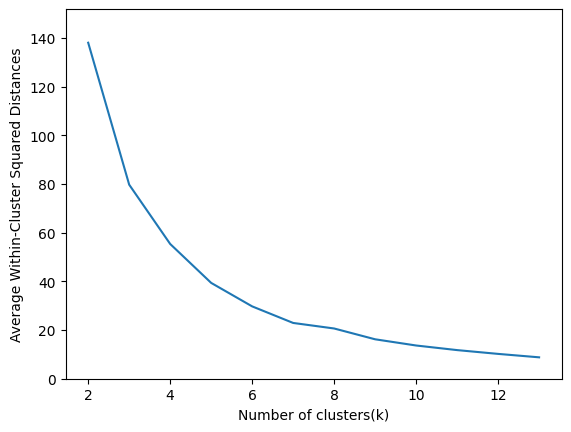

In [329]:
from sklearn.cluster import KMeans

inertia = []
for n_clusters in range(2,14):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(PD_Screen1)
    inertia.append(kmeans.inertia_ / n_clusters)

inertias = pd.DataFrame({'n_clusters': range(2,14), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0,1.1*inertias.inertia.max()))
ax.legend().set_visible(False)

In [330]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=10000,random_state=0).fit(PD_Screen1)

In [331]:
kmeans.labels_

array([0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0, 2, 0, 0, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 1, 2, 1,
       1, 1, 0, 2, 2, 1, 0, 0, 1, 1, 2, 0, 2, 0, 1, 1, 2, 1, 2, 1, 1, 0,
       0, 2, 0, 2, 0, 0], dtype=int32)

In [332]:
kmeans.cluster_centers_

array([[ 0.00934772, -0.07652063, -0.19292566, -0.12858193,  0.64427153,
         0.20263648, -0.57129271],
       [-0.50271627,  1.33471298,  0.18501349,  1.28652597,  0.05315515,
        -0.27074057,  0.57906287],
       [-1.02196886, -0.54685078,  0.03275361, -0.00375848, -0.46723636,
        -0.28352645, -1.26597909]])

In [333]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=feature_list)
centers

Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0  0.009348 -0.076521     -0.192926 -0.128582                   0.644272   
1 -0.502716  1.334713      0.185013  1.286526                   0.053155   
2 -1.021969 -0.546851      0.032754 -0.003758                  -0.467236   

   Final Response Duration  Habituation of Response Speed  
0                 0.202636                      -0.571293  
1                -0.270741                       0.579063  
2                -0.283526                      -1.265979

In [ ]:
# PD_Screen1['cluster'] = kmeans.labels_
# PD_Screen1.head()

In [334]:
from collections import Counter
kmeans_counter=Counter(kmeans.labels_)
kmeans_counter

Counter({0: 26, 1: 25, 2: 21})

In [ ]:
kmeans.labels_

In [ ]:
kmeans.n_features_in_

In [335]:
import matplotlib.pyplot as plt
import numpy as np

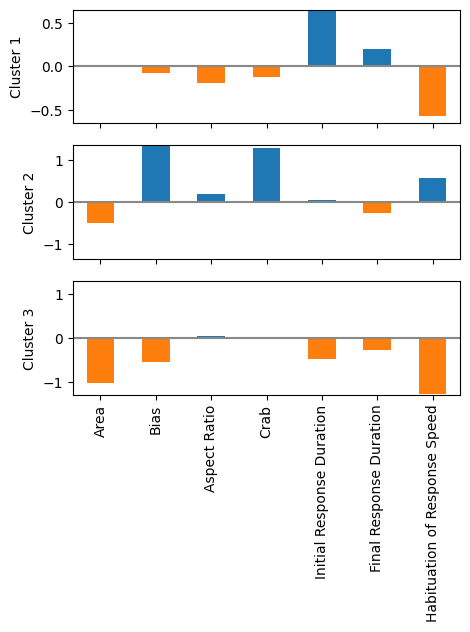

In [336]:
centers = pd.DataFrame(kmeans.cluster_centers_,columns=feature_list)

f,axes = plt.subplots(3,1, figsize=(5,5), sharex=True)
for i,ax in enumerate(axes):
    center = centers.loc[i,:]
    maxPC = 1.01*np.max(np.max(np.abs(center)))
    colors=['C0' if l>0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i+1}')
    ax.set_ylim(-maxPC, maxPC)

In [337]:
centers

Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0  0.009348 -0.076521     -0.192926 -0.128582                   0.644272   
1 -0.502716  1.334713      0.185013  1.286526                   0.053155   
2 -1.021969 -0.546851      0.032754 -0.003758                  -0.467236   

   Final Response Duration  Habituation of Response Speed  
0                 0.202636                      -0.571293  
1                -0.270741                       0.579063  
2                -0.283526                      -1.265979

### PCA Plot for Clusters

In [338]:
PD_Screen1

Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0   0.435323 -0.906314     -0.115086 -0.021343                   0.700340   
1  -0.629753 -1.528013     -0.026771  0.011223                   0.379903   
2  -0.581830 -0.672784      0.274941 -0.566572                   0.377571   
3  -0.659422  0.053918      0.233398  0.098777                  -0.432375   
4  -1.739887 -0.519592      0.825648 -0.271745                  -0.450722   
5   0.794420 -0.188445     -0.191430 -0.464986                   1.052045   
6  -0.526037 -0.680720      0.224595  0.142113                  -0.260313   
7  -0.365410 -0.687756     -0.215703  0.016773                  -0.078582   
8   0.369127 -0.079183      0.019224  0.223560                   0.002758   
9  -2.818095 -0.185355      0.756681  0.814911                  -0.799538   
10  0.565773  0.169402      0.897798  1.125118                   0.378239   
11 -1.817794  0.628416     -0.077560  1.074273                   1.337486   
12  0.033888  1.179428     -0.339174  1.159176                   1.037437   
13  0.481889  0.268568     -0.162719 -0.347119                   1.257184   
14 -1.245833 -1.529455     -0.522826 -2.412753                  -0.375936   
15 -0.643483 -0.084316      0.344746  0.363364                  -0.499865   
16 -1.210980  0.981777      1.027553  2.230579                  -0.060901   
17 -0.503193  0.271447     -0.288783  0.361493                   0.629495   
18  0.210666 -0.935409      0.654912 -0.064919                  -0.544428   
19  0.482821 -0.831724      0.085215 -0.190594                   0.658430   
20 -0.021116 -0.556289     -0.374264 -0.859489                   0.299213   
21 -0.917222  1.902491      0.036382 -0.061625                   0.723548   
22 -1.398715  1.906116      0.750431  3.286288                   0.038529   
23 -2.490101 -0.732578      1.165102  0.188152                  -2.968269   
24 -1.296054  0.928993      0.481286  0.110504                  -0.695444   
25  0.295737  2.145631      0.694349  2.435551                   0.354446   
26  0.095906  1.555216     -0.361785  1.431530                  -0.351450   
27 -0.683376  0.907917      0.476567  1.655952                   0.408012   
28 -0.292399  1.710864     -0.658005 -0.166732                   0.449412   
29 -0.983669  2.139073      0.434556  0.741345                   0.610744   
30 -0.073929  0.015643     -0.083191  0.976378                   0.541887   
31 -2.577492  1.866069     -0.605470  1.908872                   0.877229   
32 -1.074243 -0.805505      1.035401  0.089744                   0.779730   
33 -0.522733  0.472688     -0.223601  0.105326                   0.655329   
34 -0.409009 -1.608054      0.329325  0.013175                  -0.699031   
35 -0.116889  0.370639     -0.247960 -0.148182                  -0.151196   
36  0.180958 -0.152532     -0.637500  0.226765                   0.702564   
37 -0.096570 -0.593388     -0.738149  0.090971                   1.383084   
38  0.891807 -0.694207     -0.036481 -0.569111                   0.725823   
39 -1.127416  0.475633     -0.132108 -0.777706                   0.980632   
40 -1.479700  0.337219     -0.181405  0.994686                  -0.306869   
41 -0.061187  2.154176     -0.520839  1.962947                  -0.274601   
42 -1.549439 -0.229968      0.837351  0.542553                   0.148317   
43 -0.257605  0.539990      1.058949  1.878375                   0.608091   
44  0.317248  0.543765      0.451531  0.677308                  -0.106009   
45  1.236534  1.775119      1.033665  2.834567                   0.360100   
46 -0.246151  0.256950     -0.523241 -0.247121                   0.471456   
47 -0.137705 -0.777032      0.356034  0.135544                  -0.225449   
48 -1.249017  0.284072      0.123936  0.214322                  -0.374569   
49 -0.000950  0.145887      0.896943  1.524187                  -1.241006   
50  0.147024  0.212041     -0.046523 -0.637159                   1.791360   
51  

In [ ]:
# PD_Screen_test = PD_Screen[['Gene','Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
#        'Final Response Duration', 'Habituation of Response Speed']]
# print(PD_Screen_test.to_string())

In [339]:
PD_Screen_PCA = PD_Screen1[['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration', 'Final Response Duration', 'Habituation of Response Speed']]
PD_Screen_PCA = pd.concat([PD_Screen_PCA, centers], ignore_index=True)

Cluster_labels = pd.Series(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

PD_Screen_PCA_labels = pd.concat([PD_Screen_Genes, Cluster_labels], ignore_index=True)

print(PD_Screen_PCA.to_string())
print(PD_Screen_PCA_labels.to_string())

        Area      Bias  Aspect Ratio      Crab  Initial Response Duration  Final Response Duration  Habituation of Response Speed
0   0.435323 -0.906314     -0.115086 -0.021343                   0.700340                 0.374578                      -0.852143
1  -0.629753 -1.528013     -0.026771  0.011223                   0.379903                -0.439289                      -2.570717
2  -0.581830 -0.672784      0.274941 -0.566572                   0.377571                 1.459391                      -1.062773
3  -0.659422  0.053918      0.233398  0.098777                  -0.432375                -0.551079                      -1.131573
4  -1.739887 -0.519592      0.825648 -0.271745                  -0.450722                -0.085498                      -1.584807
5   0.794420 -0.188445     -0.191430 -0.464986                   1.052045                 0.666279                       0.220281
6  -0.526037 -0.680720      0.224595  0.142113                  -0.260313                -

In [357]:
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(PD_Screen_PCA)
# kmeans_PCA = KMeans(n_clusters=4, n_init=10000, random_state=0).fit(reduced_data)

In [349]:
import umap

fit = umap.UMAP()
umapped = fit.fit_transform(PD_Screen_PCA)
# umapped = umap.UMAP().fit(PD_Screen_PCA)

In [350]:
umapped

array([[1.7256669, 3.5937393],
       [3.5814583, 1.5114329],
       [2.5589123, 3.1717703],
       [4.049162 , 1.9660549],
       [4.3440723, 1.6550618],
       [1.8314368, 4.5228066],
       [3.8275378, 1.7139374],
       [3.481991 , 1.6165724],
       [2.7756863, 3.866904 ],
       [4.646165 , 2.2334232],
       [2.8027313, 6.09236  ],
       [3.3720863, 5.469738 ],
       [3.6050694, 6.086169 ],
       [2.0117793, 3.5584695],
       [2.8768768, 2.4867077],
       [4.429392 , 4.1556854],
       [4.1818438, 6.6383805],
       [2.5348132, 5.270493 ],
       [3.3769772, 1.1326512],
       [1.6623429, 3.0882814],
       [2.2800086, 3.2655284],
       [4.395685 , 5.508985 ],
       [4.5326247, 6.582935 ],
       [4.678466 , 1.8553966],
       [4.732243 , 4.502801 ],
       [4.8430586, 6.6333647],
       [4.9437337, 6.0988493],
       [3.7943933, 6.244331 ],
       [4.2019753, 5.3848786],
       [4.4721494, 6.1434016],
       [2.6829853, 5.7176814],
       [4.4173503, 6.027026 ],
       [

In [351]:
umap_df = pd.DataFrame({'x':umapped[:,0],'y':umapped[:,1]})
df_PCA_dropped = umap_df.iloc[:-3]
df_clusters = umap_df.tail(3).reset_index()
print(df_PCA_dropped.to_string())
print(df_clusters)

           x         y
0   1.725667  3.593739
1   3.581458  1.511433
2   2.558912  3.171770
3   4.049162  1.966055
4   4.344072  1.655062
5   1.831437  4.522807
6   3.827538  1.713937
7   3.481991  1.616572
8   2.775686  3.866904
9   4.646165  2.233423
10  2.802731  6.092360
11  3.372086  5.469738
12  3.605069  6.086169
13  2.011779  3.558470
14  2.876877  2.486708
15  4.429392  4.155685
16  4.181844  6.638381
17  2.534813  5.270493
18  3.376977  1.132651
19  1.662343  3.088281
20  2.280009  3.265528
21  4.395685  5.508985
22  4.532625  6.582935
23  4.678466  1.855397
24  4.732243  4.502801
25  4.843059  6.633365
26  4.943734  6.098849
27  3.794393  6.244331
28  4.201975  5.384879
29  4.472149  6.143402
30  2.682985  5.717681
31  4.417350  6.027026
32  3.720340  2.091203
33  2.853611  5.130485
34  3.441381  1.339985
35  4.272664  4.771746
36  2.441798  4.492357
37  1.983860  4.436403
38  1.686997  3.962115
39  2.719235  4.650492
40  4.244493  2.193343
41  4.975401  5.962059
42  4.38762

In [ ]:
# import umap.plot

# umap.plot.points(umapped)

In [ ]:
# len(kmeans_PCA.labels_)

In [ ]:
# PD_Screen_Genes

In [362]:
df_PCA = pd.DataFrame({'PCA_x':reduced_data[:,0],'PCA_y':reduced_data[:,1]})
df_PCA_dropped = df_PCA.iloc[:-3]
df_clusters = df_PCA.tail(3).reset_index()
print(df_PCA_dropped.to_string())
print(df_clusters)

       PCA_x     PCA_y
0   1.312235 -0.979420
1   2.554498  0.536950
2   1.532352 -0.586042
3   0.667848  0.814331
4   1.406479  1.311627
5   0.533406 -1.907979
6   1.179632  0.508534
7   1.525049  0.384202
8   0.532199 -0.270752
9  -0.205140  2.105463
10  0.052223 -0.337017
11 -0.848584 -0.288293
12 -1.236036 -1.176804
13  1.102500 -1.125832
14  3.573334  0.529577
15 -0.162816  0.239102
16 -1.606794  0.975834
17  0.311463 -0.628119
18  0.991984  0.254301
19  1.830512 -0.502942
20  1.629103 -0.624544
21 -1.984118 -0.888916
22 -3.011179  1.097412
23  0.819339  3.626213
24 -0.893262  0.924158
25 -2.874567 -0.291363
26 -1.797828  0.187363
27 -1.303998 -0.247794
28 -1.751487 -1.285083
29 -1.685308 -0.074055
30  0.109026 -0.543642
31 -3.003488  0.070210
32  1.474526 -0.041706
33 -0.046320 -0.816330
34  1.915253  0.803113
35 -0.853336 -0.581949
36  0.472927 -0.961516
37  0.740575 -1.379256
38  1.234473 -1.235393
39  0.274650 -0.640065
40  0.888060  1.525374
41 -3.441965 -0.281287
42  0.50584

In [ ]:
# df_PCA_dropped2 = df_PCA_dropped.iloc[:-566]
# df_PCA_others = df_PCA_dropped.tail(566).reset_index()
# print(df_PCA_dropped2)
# print(df_PCA_others)

In [ ]:
# df_PCA_others['Gene'] = PD_Screen_other_Genes.reset_index().drop(columns=['index'])
# df_PCA_others

In [363]:
print(PD_Screen_Genes.reset_index().drop(columns=['index']))

        Gene
0    C18H9.3
1    M03D4.4
2     R151.1
3    ZK858.6
4      anc-1
5      aps-2
6      bar-1
7     bcl-11
8      bra-1
9      cbp-1
10     cca-1
11     cdh-4
12     chd-7
13     cls-3
14     cnt-2
15     cor-1
16    daf-18
17     daf-6
18     dhc-1
19    dhcr-7
20     dhp-1
21     dip-2
22     dys-1
23     epi-1
24     exc-7
25     fkh-7
26     gab-1
27     gap-2
28     glr-1
29     glr-2
30    gpa-16
31     hcp-1
32     hda-4
33     hmp-2
34     irx-1
35  jmjd-1.1
36  jmjd-3.3
37     kqt-1
38    lron-8
39   math-33
40     mbk-1
41     met-1
42    mrck-1
43     mtm-5
44     nab-1
45     nhx-5
46     nlg-1
47    npax-2
48     nrx-1
49     pax-2
50     pop-1
51     pph-5
52    ptr-10
53     ptr-6
54     rbr-2
55     rme-6
56     row-1
57    set-11
58    set-16
59    set-24
60     set-4
61     shn-1
62     sin-3
63     slo-1
64     smg-4
65    snf-11
66    spas-1
67    tbx-38
68     ubr-4
69   unknown
70    vab-10
71     ztf-6


In [364]:
df_PCA_dropped

PCA_x     PCA_y
0   1.312235 -0.979420
1   2.554498  0.536950
2   1.532352 -0.586042
3   0.667848  0.814331
4   1.406479  1.311627
5   0.533406 -1.907979
6   1.179632  0.508534
7   1.525049  0.384202
8   0.532199 -0.270752
9  -0.205140  2.105463
10  0.052223 -0.337017
11 -0.848584 -0.288293
12 -1.236036 -1.176804
13  1.102500 -1.125832
14  3.573334  0.529577
15 -0.162816  0.239102
16 -1.606794  0.975834
17  0.311463 -0.628119
18  0.991984  0.254301
19  1.830512 -0.502942
20  1.629103 -0.624544
21 -1.984118 -0.888916
22 -3.011179  1.097412
23  0.819339  3.626213
24 -0.893262  0.924158
25 -2.874567 -0.291363
26 -1.797828  0.187363
27 -1.303998 -0.247794
28 -1.751487 -1.285083
29 -1.685308 -0.074055
30  0.109026 -0.543642
31 -3.003488  0.070210
32  1.474526 -0.041706
33 -0.046320 -0.816330
34  1.915253  0.803113
35 -0.853336 -0.581949
36  0.472927 -0.961516
37  0.740575 -1.379256
38  1.234473 -1.235393
39  0.274650 -0.640065
40  0.888060  1.525374
41 -3.441965 -0.281287
42  0.505849  0.878553
43 -0.707269  0.126856
44 -0.616422  0.048762
45 -2.820687 -0.672466
46  0.508751 -0.455660
47  1.546923  0.402405
48  0.415075  0.842095
49 -0.903191  1.443569
50  0.264571 -2.060243
51  0.454111 -1.091609
52 -3.328198 -1.133426
53 -0.859347  1.301808
54  1.486227  1.688930
55  2.386020 -1.527423
56  1.651950  0.562632
57 -0.155361 -0.703691
58 -2.936401  3.523204
59 -0.631211 -0.543881
60  0.085653  0.920490
61 -1.237531 -0.021210
62  1.178823  0.398737
63 -1.477990 -1.374579
64 -0.559375  0.027262
65  0.792742 -0.406266
66  0.204682 -0.527688
67  1.020127  0.584091
68 -0.169348 -0.339598
69  0.231853  0.676245
70  1.569863 -0.867234
71 -0.015232 -0.069914

In [365]:
# df_PCA = pd.DataFrame({'PCA_x':reduced_data[:,0],'PCA_y':reduced_data[:,1]})
df_PCA_dropped['KMeans'] = kmeans.labels_
# df_PCA['KMeans_PCA'] = kmeans_PCA.labels_
df_PCA_dropped['Gene'] = PD_Screen_Genes.reset_index().drop(columns=['index'])
df_PCA_dropped

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_28532/350561850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PCA_dropped['KMeans'] = kmeans.labels_
/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_28532/350561850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PCA_dropped['Gene'] = PD_Screen_Genes.reset_index().drop(columns=['index'])


PCA_x     PCA_y  KMeans      Gene
0   1.312235 -0.979420       0   C18H9.3
1   2.554498  0.536950       2   M03D4.4
2   1.532352 -0.586042       0    R151.1
3   0.667848  0.814331       2   ZK858.6
4   1.406479  1.311627       2     anc-1
5   0.533406 -1.907979       0     aps-2
6   1.179632  0.508534       2     bar-1
7   1.525049  0.384202       2    bcl-11
8   0.532199 -0.270752       0     bra-1
9  -0.205140  2.105463       2     cbp-1
10  0.052223 -0.337017       0     cca-1
11 -0.848584 -0.288293       1     cdh-4
12 -1.236036 -1.176804       1     chd-7
13  1.102500 -1.125832       0     cls-3
14  3.573334  0.529577       2     cnt-2
15 -0.162816  0.239102       0     cor-1
16 -1.606794  0.975834       1    daf-18
17  0.311463 -0.628119       0     daf-6
18  0.991984  0.254301       2     dhc-1
19  1.830512 -0.502942       0    dhcr-7
20  1.629103 -0.624544       0     dhp-1
21 -1.984118 -0.888916       1     dip-2
22 -3.011179  1.097412       1     dys-1
23  0.819339  3.626213       2     epi-1
24 -0.893262  0.924158       1     exc-7
25 -2.874567 -0.291363       1     fkh-7
26 -1.797828  0.187363       1     gab-1
27 -1.303998 -0.247794       1     gap-2
28 -1.751487 -1.285083       1     glr-1
29 -1.685308 -0.074055       1     glr-2
30  0.109026 -0.543642       0    gpa-16
31 -3.003488  0.070210       1     hcp-1
32  1.474526 -0.041706       2     hda-4
33 -0.046320 -0.816330       0     hmp-2
34  1.915253  0.803113       2     irx-1
35 -0.853336 -0.581949       1  jmjd-1.1
36  0.472927 -0.961516       0  jmjd-3.3
37  0.740575 -1.379256       0     kqt-1
38  1.234473 -1.235393       0    lron-8
39  0.274650 -0.640065       0   math-33
40  0.888060  1.525374       2     mbk-1
41 -3.441965 -0.281287       1     met-1
42  0.505849  0.878553       2    mrck-1
43 -0.707269  0.126856       1     mtm-5
44 -0.616422  0.048762       1     nab-1
45 -2.820687 -0.672466       1     nhx-5
46  0.508751 -0.455660       0     nlg-1
47  1.546923  0.402405       2    npax-2
48  0.415075  0.842095       2     nrx-1
49 -0.903191  1.443569       1     pax-2
50  0.264571 -2.060243       0     pop-1
51  0.454111 -1.091609       0     pph-5
52 -3.328198 -1.133426       1    ptr-10
53 -0.859347  1.301808       1     ptr-6
54  1.486227  1.688930       2     rbr-2
55  2.386020 -1.527423       0     rme-6
56  1.651950  0.562632       2     row-1
57 -0.155361 -0.703691       0    set-11
58 -2.936401  3.523204       1    set-16
59 -0.631211 -0.543881       1    set-24
60  0.085653  0.920490       2     set-4
61 -1.237531 -0.021210       1     shn-1
62  1.178823  0.398737       2     sin-3
63 -1.477990 -1.374579       1     slo-1
64 -0.559375  0.027262       1     smg-4
65  0.792742 -0.406266       0    snf-11
66  0.204682 -0.527688       0    spas-1
67  1.020127  0.584091       2    tbx-38
68 -0.169348 -0.339598       0     ubr-4
69  0.231853  0.676245       2   unknown
70  1.569863 -0.867234       0    vab-10
71 -0.015232 -0.069914       0     ztf-6

In [366]:
df_clusters['Clusters'] = ['Cluster 1','Cluster 2','Cluster 3']
df_clusters

index     PCA_x     PCA_y   Clusters
0     72  0.665358 -0.782657  Cluster 1
1     73 -1.694783  0.034613  Cluster 2
2     74  1.186350  0.919627  Cluster 3

In [367]:
my_palette = plt.cm.get_cmap("tab10", len(centers.index))

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_28532/3253278561.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("tab10", len(centers.index))


In [ ]:
# sns.color_palette("tab10")

In [ ]:
# print(sns.color_palette("tab10").as_hex())

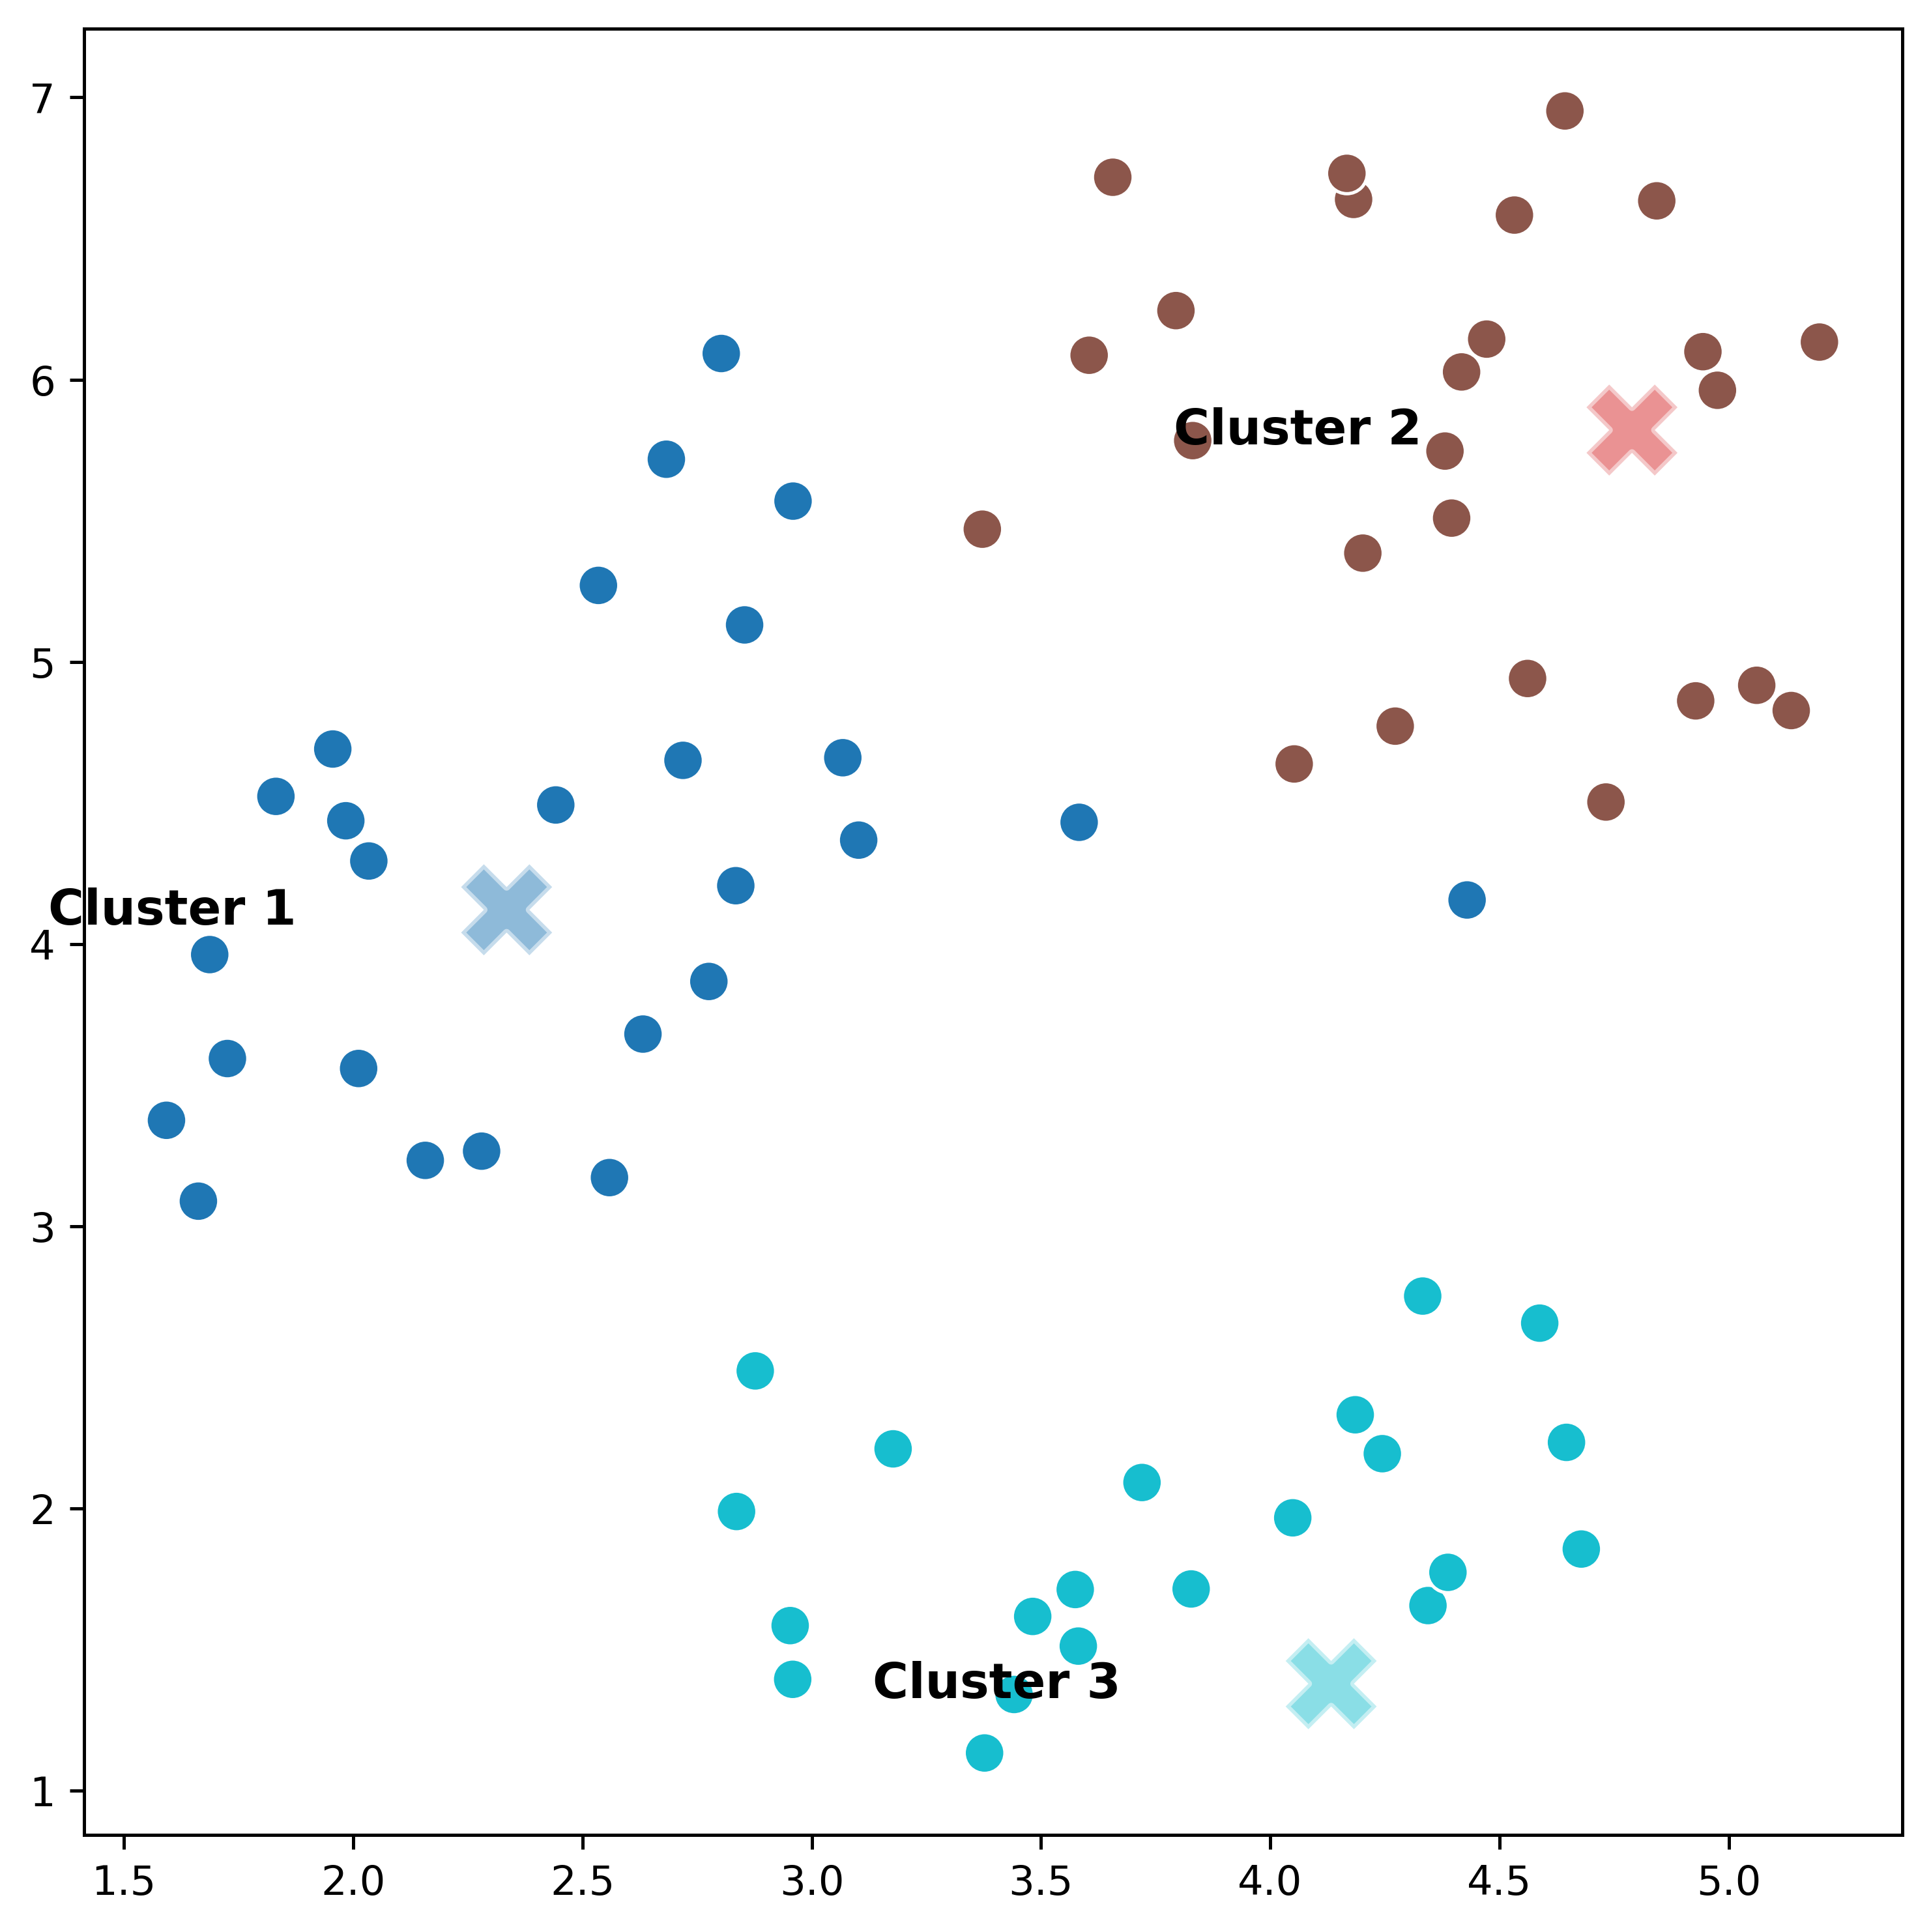

In [356]:
fig, axs = plt.subplots(figsize=(8, 8), dpi=450)

sns.scatterplot(data=df_PCA_dropped, x="x", y="y", hue="KMeans", legend=False, palette = my_palette, s=100)

def label_marker(x, y, val, ax, markersize):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.05, point['y']-0.05, str(point['val']), fontsize = markersize, weight='bold')

# label_marker(df_PCA_dropped.x, df_PCA_dropped.y, df_PCA_dropped.Gene, plt.gca(), 'x-small') 

# sns.scatterplot(data=df_PCA_others, x="PCA_x", y="PCA_y", c='k',legend=False, alpha = 0.2)

sns.scatterplot(data=df_clusters, x="x", y="y", hue="Clusters", legend=False, palette = ['#1f77b4', '#d62728', '#17becf'], marker='X',s=500, alpha = 0.5)
# 

def label_point(x, y, val, ax, markersize):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-1, point['y']-0.05, str(point['val']), fontsize = markersize, weight='bold')
        
label_point(df_clusters.x, df_clusters.y, df_clusters.Clusters, plt.gca(), 'large') 

axs.set_title("")
axs.set_xlabel("")
axs.set_ylabel("")



# plt.savefig('/Users/Joseph/Desktop/ASD_PCA_Cluster_IBANGS_NoNewModel.png', bbox_inches='tight')
plt.show()



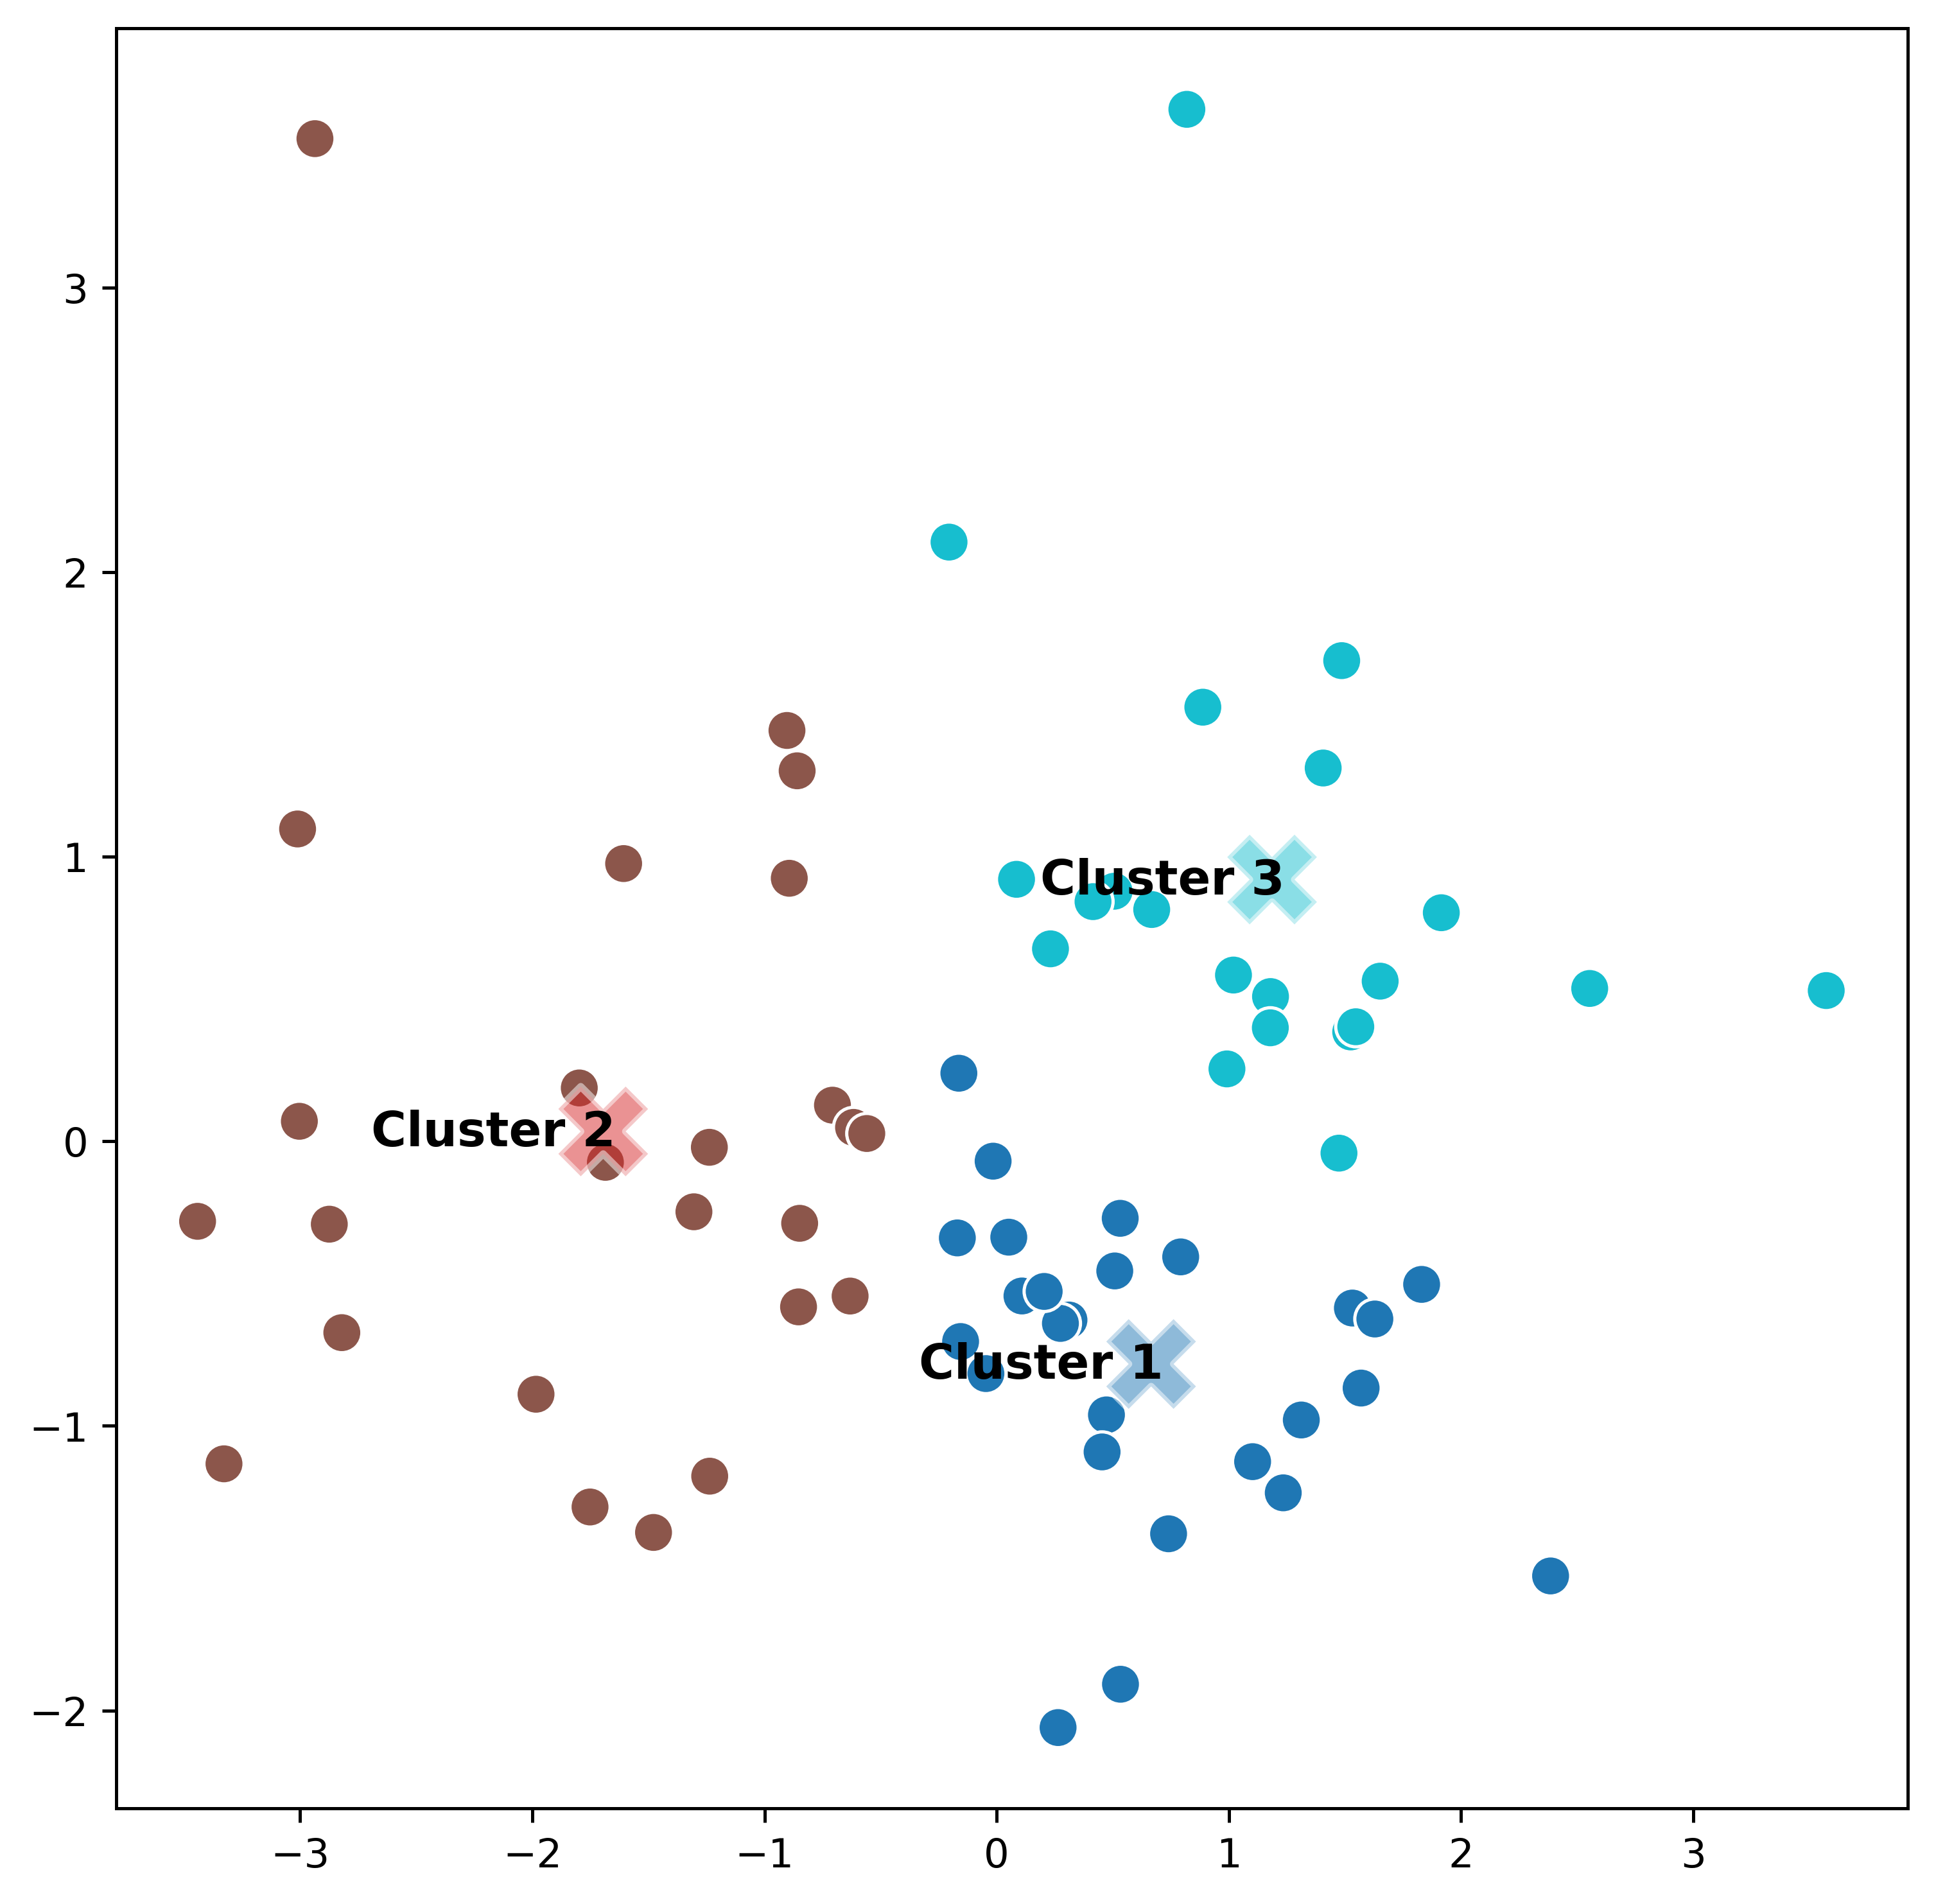

In [371]:
fig, axs = plt.subplots(figsize=(8, 8), dpi=450)

sns.scatterplot(data=df_PCA_dropped, x="PCA_x", y="PCA_y", hue="KMeans", legend=False, palette = my_palette, s=100)

def label_marker(x, y, val, ax, markersize):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.05, point['y']-0.05, str(point['val']), fontsize = markersize, weight='bold')

# label_marker(df_PCA_dropped.PCA_x, df_PCA_dropped.PCA_y, df_PCA_dropped.Gene, plt.gca(), 'x-small') 

# sns.scatterplot(data=df_PCA_others, x="PCA_x", y="PCA_y", c='k',legend=False, alpha = 0.2)

sns.scatterplot(data=df_clusters, x="PCA_x", y="PCA_y", hue="Clusters", legend=False, palette = ['#1f77b4', '#d62728', '#17becf'], marker='X',s=500, alpha = 0.5)
# ['#1f77b4', '#d62728', '#e377c2', '#17becf']

def label_point(x, y, val, ax, markersize):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-1, point['y']-0.05, str(point['val']), fontsize = markersize, weight='bold')
        
label_point(df_clusters.PCA_x, df_clusters.PCA_y, df_clusters.Clusters, plt.gca(), 'large') 

axs.set_title("")
axs.set_xlabel("")
axs.set_ylabel("")



plt.savefig('/Users/Joseph/Desktop/ASD_PCA_Cluster_IBANGS_NoNewModel.png', bbox_inches='tight')
plt.show()



In [372]:
Gene_KMeans = df_PCA_dropped[['KMeans','Gene']]

Gene_KMeans = Gene_KMeans.rename(columns={"KMeans":"Cluster"})

Gene_KMeans['Cluster'] = Gene_KMeans['Cluster'] + 1

print(Gene_KMeans)

Gene_KMeans.to_csv('/Users/Joseph/Desktop/ASD_Clustered_Gene_IBANGS_NoNewModel.csv')

    Cluster      Gene
0         1   C18H9.3
1         3   M03D4.4
2         1    R151.1
3         3   ZK858.6
4         3     anc-1
5         1     aps-2
6         3     bar-1
7         3    bcl-11
8         1     bra-1
9         3     cbp-1
10        1     cca-1
11        2     cdh-4
12        2     chd-7
13        1     cls-3
14        3     cnt-2
15        1     cor-1
16        2    daf-18
17        1     daf-6
18        3     dhc-1
19        1    dhcr-7
20        1     dhp-1
21        2     dip-2
22        2     dys-1
23        3     epi-1
24        2     exc-7
25        2     fkh-7
26        2     gab-1
27        2     gap-2
28        2     glr-1
29        2     glr-2
30        1    gpa-16
31        2     hcp-1
32        3     hda-4
33        1     hmp-2
34        3     irx-1
35        2  jmjd-1.1
36        1  jmjd-3.3
37        1     kqt-1
38        1    lron-8
39        1   math-33
40        3     mbk-1
41        2     met-1
42        3    mrck-1
43        2     mtm-5
44        

In [ ]:
# from plotly.subplots import make_subplots
# import plotly.express as px
# import plotly.graph_objects as go

# fig = make_subplots(cols=2, rows=2,
#                     specs=[[{"type": "polar"} for _ in range(2)] for _ in range(2)],
#                     # subplot_titles=("Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5")
#                    )


# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[0], theta = centers.columns, fill="toself",name="(Cluster 1)"),
#     row=1, col=1
# )


# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[1], theta = centers.columns, fill="toself",name="(Cluster 2)"),
#     row=1, col=2
# )

# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[2], theta = centers.columns, fill="toself",name="(Cluster 3)"),
#     row=2, col=1
# )

# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[3], theta = centers.columns, fill="toself",name="(Cluster 4)"),
#     row=2, col=2
# )



# fig.update_layout(
#   polar=dict(
#     radialaxis=dict(
#       visible=True
#     ),
#   ),
#   showlegend=False
# )

# fig.update_layout(height=1500, width=1000, template='plotly_dark',title_text="5 'Profiles' associated with PD genotype")
# fig.update_polars(radialaxis=dict(range=[-3, 3]))
# fig.show()

In [373]:
# centers.loc[row].values.flatten().tolist()
# list(centers)[0:]
# cols=['Habituation of Response Duration','Bias','Kink','Final Response Probability','Curve','Instantaneous Speed','Width']
# centers=centers[cols]
centers

Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0  0.009348 -0.076521     -0.192926 -0.128582                   0.644272   
1 -0.502716  1.334713      0.185013  1.286526                   0.053155   
2 -1.021969 -0.546851      0.032754 -0.003758                  -0.467236   

   Final Response Duration  Habituation of Response Speed  
0                 0.202636                      -0.571293  
1                -0.270741                       0.579063  
2                -0.283526                      -1.265979

In [374]:
centers_reorg=centers[['Habituation of Response Speed',
              'Area',
             'Bias',
             'Aspect Ratio',
             'Crab',
             'Initial Response Duration',
             'Final Response Duration']]

centers_reorg

Habituation of Response Speed      Area      Bias  Aspect Ratio      Crab  \
0                      -0.571293  0.009348 -0.076521     -0.192926 -0.128582   
1                       0.579063 -0.502716  1.334713      0.185013  1.286526   
2                      -1.265979 -1.021969 -0.546851      0.032754 -0.003758   

   Initial Response Duration  Final Response Duration  
0                   0.644272                 0.202636  
1                   0.053155                -0.270741  
2                  -0.467236                -0.283526

In [375]:
categories = ['Habituation of Response Speed',
              'Area',
             'Bias',
             'Aspect Ratio',
             'Crab',
             'Initial Response Duration',
             'Final Response Duration']


categories

['Habituation of Response Speed',
 'Area',
 'Bias',
 'Aspect Ratio',
 'Crab',
 'Initial Response Duration',
 'Final Response Duration']

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_28532/1343363049.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("tab10", len(centers.index)+1)


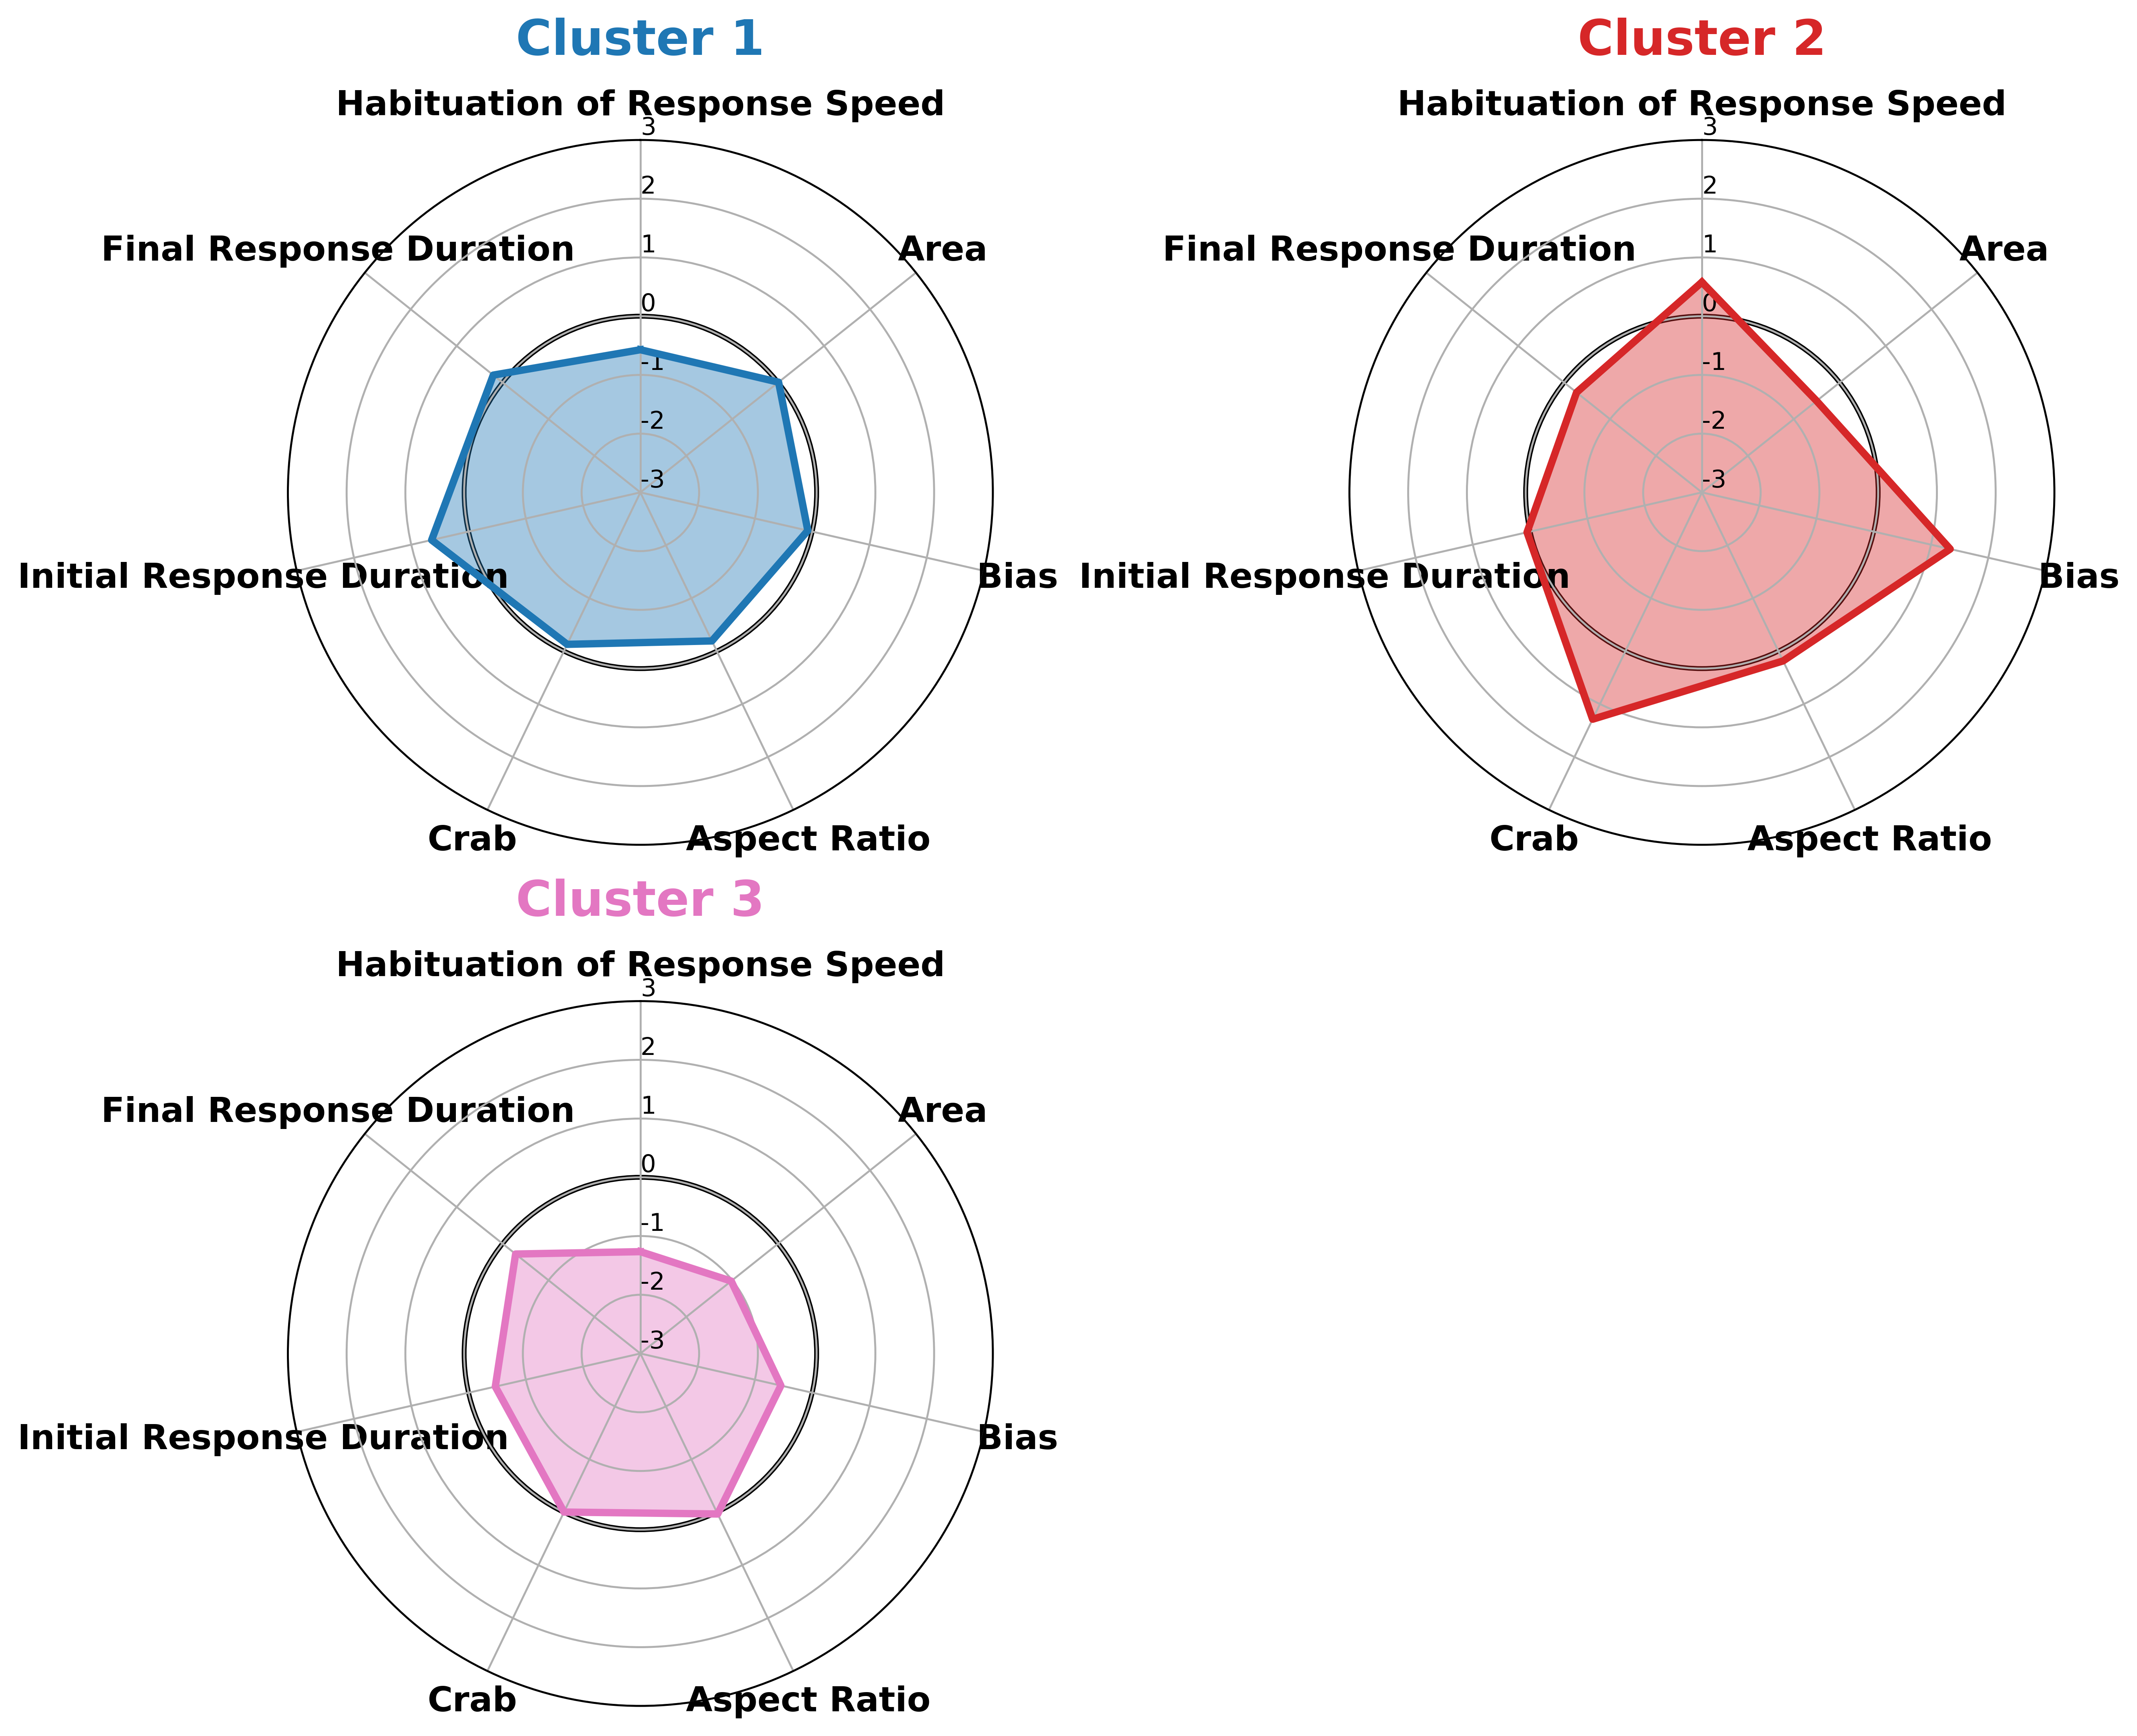

In [377]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import matplotlib
import pylab as pl 
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color):

    # number of variable
    categories=list(centers_reorg)[0:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='k', size=14, weight = 'bold')

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5], ["-5","-4","-3","-2","-1","0","1","2","3","4","5"], color="k", size=10)
    plt.ylim(-3,3)

    # Add a dark circle at 0 for N2
    circle = pl.Circle((0, 0), 3, transform=ax.transData._b, color="k", linewidth=2,fill = False)
    ax.add_artist(circle)

    # Ind1
    values=centers_reorg.loc[row].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=3, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=20, color=color, y=1.1, weight='bold')

    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=450
plt.figure(figsize=(12, 12), dpi=my_dpi, layout='compressed')
# Create a color palette:
my_palette = plt.cm.get_cmap("tab10", len(centers.index)+1)
 
# Loop to plot
for row in range(0, len(centers.index)):
    make_spider(row=row, title='Cluster '+str(centers_reorg.index[row]+1), color=my_palette(row))
# plt.savefig('/Users/Joseph/Desktop/ASD_ClusterProfiles_IBANGS_NoNewModel.png', bbox_inches='tight')
plt.show()

### Stopped Here...

## Plotting Individual Genotypes

In [ ]:
feature_list = ['Habituation of Response Speed',
              'Area',
             'Bias',
             'Aspect Ratio',
             'Crab',
             'Initial Response Duration',
             'Final Response Duration']

feature_list_with_gene = ['Gene',
                          'Habituation of Response Speed',
                          'Area',
                         'Bias',
                         'Aspect Ratio',
                         'Crab',
                         'Initial Response Duration',
                         'Final Response Duration']
PD_Screen_plot = PD_Screen[feature_list_with_gene]

cols=feature_list_with_gene
PD_Screen_plot=PD_Screen_plot[cols]
PD_Screen_plot

In [ ]:
PD_Screen_cluster = PD_Screen[feature_list_with_gene]
PD_Screen_cluster['Cluster'] = kmeans.labels_
PD_Screen_cluster.head()

In [ ]:
cols=['Gene',
      'Habituation of Response Speed',
      'Area',
     'Bias',
     'Aspect Ratio',
     'Crab',
     'Initial Response Duration',
     'Final Response Duration','Cluster']
PD_Screen_cluster=PD_Screen_cluster[cols]
PD_Screen_cluster

In [ ]:
PD_Screen_plot['Gene'][0]

PD_Screen_plot.Gene[PD_Screen_plot.Gene == 'C29E4.10'].index

In [ ]:
import ipywidgets as widgets

Gene_Dropdown = widgets.Dropdown(
                    options=list(PD_Screen_plot['Gene']),
                    value=PD_Screen_plot['Gene'][0],
                    description='Gene:',
                    disabled=False,
                )
display(Gene_Dropdown)

In [ ]:
PD_Screen_cluster.loc[PD_Screen_cluster.Gene[PD_Screen_cluster.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[:]

In [ ]:
PD_Screen_plot.loc[PD_Screen_plot.Gene[PD_Screen_plot.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[:]

In [ ]:

# # number of variable
# categories=list(PD_Screen_plot)[1:]
# N = len(categories)
 
# # We are going to plot the first line of the data frame.
# # But we need to repeat the first value to close the circular graph:
# values=PD_Screen_plot.loc[PD_Screen_plot.Gene[PD_Screen_plot.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[1:]
# values += values[:1]
# values
 
# # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]
 
# # Initialise the spider plot
# ax = plt.subplot(111, polar=True)

# # If you want the first axis to be on top:
# ax.set_theta_offset(pi / 2)
# ax.set_theta_direction(-1)

# # Draw one axe per variable + add labels
# plt.xticks(angles[:-1], categories, color='grey', size=8)



# # Draw ylabels
# ax.set_rlabel_position(0)
# plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5], ["-5","-4","-3","-2","-1","0","1","2","3","4","5"], color="grey", size=7)
# plt.ylim(-4,4)
 
# # Plot data
# ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# # Fill area
# ax.fill(angles, values, 'b', alpha=0.2)

# # Show the graph
# plt.show()

In [ ]:
# ------- PART 1: Create background
 
# number of variable
categories=list(PD_Screen_plot)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)

 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5], ["-5","-4","-3","-2","-1","0","1","2","3","4","5"], color="grey", size=7)
plt.ylim(-5,2)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
cluster_row = PD_Screen_cluster.loc[PD_Screen_cluster.Gene[PD_Screen_cluster.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[-1]
values=centers.loc[cluster_row].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', color="grey",label=f"Cluster {cluster_row+1}")
ax.fill(angles, values, 'grey', alpha=0.4)
 
# Ind2
values=PD_Screen_plot.loc[PD_Screen_plot.Gene[PD_Screen_plot.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[1:]
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', color="orange",label=f"{Gene_Dropdown.value}")
ax.fill(angles, values, 'r', alpha=0.2)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
# plt.savefig(f'/Users/Joseph/Desktop/{Gene_Dropdown.value}_profile.png', format='png', dpi=450, bbox_inches='tight')
plt.show()
# plt.savefig(f'/Users/Joseph/Desktop/NRSC510B/{Gene_Dropdown.value}_profile.png', format='png', dpi=450, bbox_inches='tight')